## EvadeGANz ##

In [ ]:
# Data & Classifier Imports
import time
import random
import scipy as sp
import pandas as pd
import numpy as np
from numpy import ones, zeros
from scipy.sparse import vstack
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import confusion_matrix
from data import Data
from features import get_features
from features import plot_features
from classifier import fit_clf, evaluate

# Attacker imports
import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.sparse import SparseTensor
import keras
import keras.backend as K
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers import ActivityRegularization, Dropout
from keras.layers.merge import Maximum, Concatenate, Multiply
from keras.models import Model, load_model
from keras.optimizers import Adam, Nadam, Adagrad
from keras.regularizers import l1, l2, l1_l2
from keras.losses import binary_crossentropy
from keras.utils.vis_utils import plot_model
from attack import EvadeGAN
from attack import binarise
from attack import output_progress, plot_TPR_metrics, plot_confusion_matrix
from IPython.core.debugger import set_trace
from IPython.display import display, HTML, Image

%matplotlib inline
%load_ext autoreload

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Main directories

In [ ]:
TOP_DIR = '../data/'
PLOT_DIR = TOP_DIR + 'plots/'
ADV_DIR = PLOT_DIR + 'adversarial/'
TPR_DIR = PLOT_DIR + 'TPR/'
GAN_DIR  = TOP_DIR + 'GAN/'

Fix the random seeds for reproducibility

In [ ]:
# Fix the random seeds for reproducibility
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

print("\u0044\u006f\u006e\u0065\u0020\u2713")

Done ✓


### **1. Load & Split the Dataset**

**Feature selection** based on the $ \chi^2 $ test to pick the top 10K features that are most correlated with class labels _(most discriminative between the two classes)._

In [ ]:
# Class labels, could change them with WGAN
MAL_LABEL = 1
GOOD_LABEL = 0

n_features = 10000

# Load data
%autoreload
data = Data(n_features=n_features)

# Split data
X_train, X_test, Y_train, Y_test = data.split(test_size=0.3, random_state=0)

# Adjust Class Labels [Goodware is 0 or -1]
Y_train[Y_train == 0] = GOOD_LABEL
Y_test[Y_test == 0] = GOOD_LABEL
Y_train[Y_train == 1] = MAL_LABEL
Y_train[Y_train == 1] = MAL_LABEL

# Malware & its split subsets
X_malware = data.get_X_malware()
X_mal_train = data.get_X_mal_train()
X_mal_test = data.get_X_mal_test()

# Goodware & its split subsets
X_goodware = data.get_X_goodware()
X_good_train = data.get_X_good_train()
X_good_test = data.get_X_good_test()


Starting to read the data shelf
Finished reading the data shelf. Elapsed time: 0.0037669512500012087 minutes


### **2. Fit the Classifier (Target Model)**

In [ ]:
# Fit the classifier
model = fit_clf(X_train, Y_train, C=1.0, weight={1:2, 0:1}, linearsvc=True,
                fname=f'c_1_top_{n_features}_test_0.3_weight_2_linearsvc')

Model c_1_top_10000_test_0.3_weight_2_linearsvc Loaded


In [ ]:
# Get model parameters (either LinearSVC or SVC)
C = model.C
if type(model)==LinearSVC:
    weights = model.coef_.flatten()
elif type(model)==SVC:
    weights = model.coef_.toarray().flatten()
intercept = model.intercept_[0]
print("C =", C)
print("Weights =", np.round(weights,4))
print(f"Non-zero Weights % = "
      f"{100*np.nonzero(weights)[0].shape[0]/weights.shape[0]:.2f}%")
print("Intercept =", intercept)

C = 1.0
Weights = [-0.      0.4176  0.1756 ...  0.      0.      0.    ]
Non-zero Weights % = 77.28%
Intercept = -1.308508950646257


**Feature weights** (insight into the model **complexity**  and
**interpretability**)

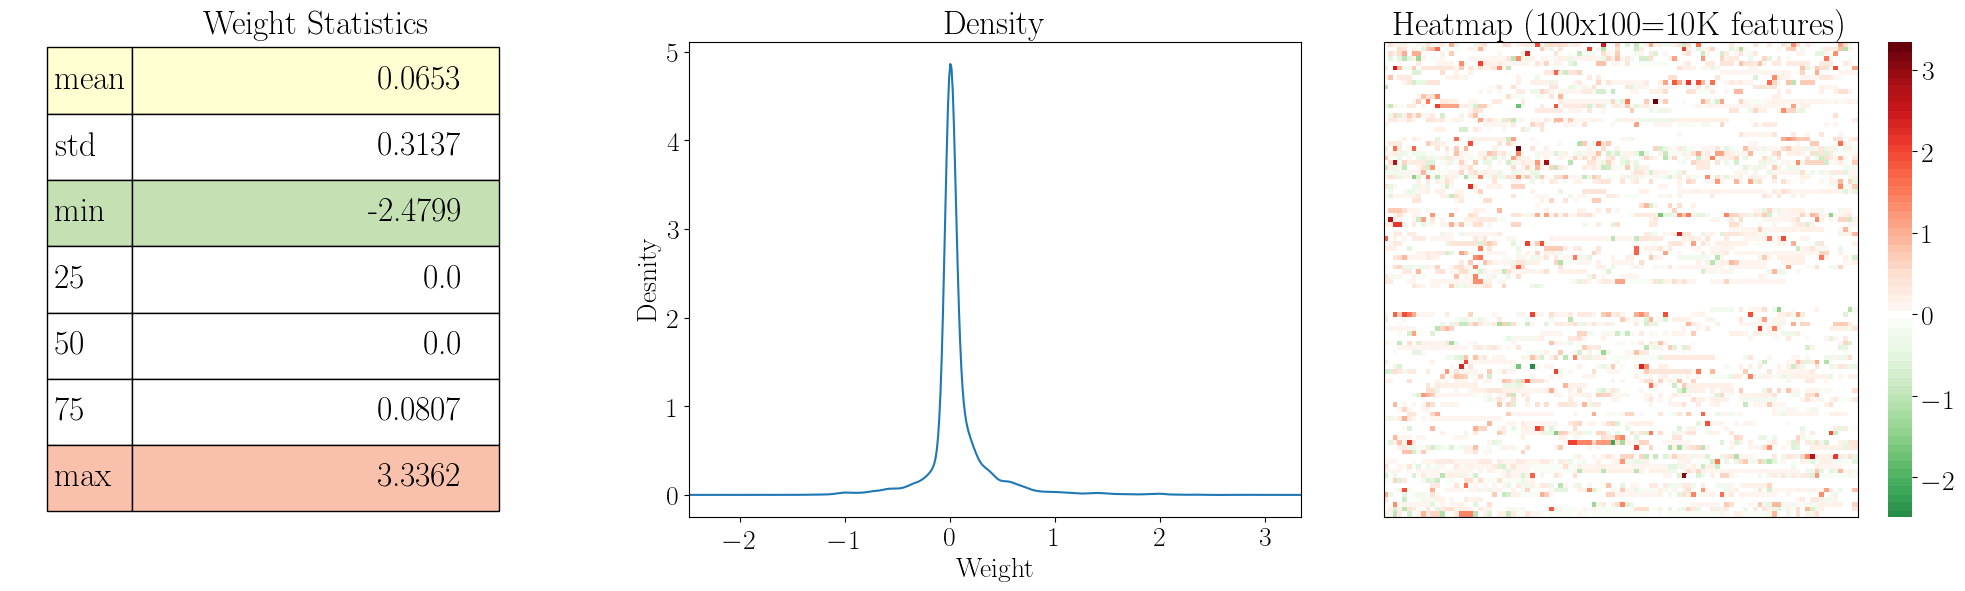

In [ ]:
%autoreload

plot_features(model)

### **3. Label the Data using the Target Model**

In [ ]:
print("TP (Malware) [True Positives, from each of the training & test sets]\n"
      "====================================================================")

# From the training set
# From the training set
Y_pred = model.predict(X_mal_train)
TP_train = X_mal_train[np.where(Y_pred==MAL_LABEL)[0]]
print(f'All mal_train: {X_mal_train.shape[0]}')
print(f'TP_train: {TP_train.shape[0]} '
      f'({100*TP_train.shape[0]/X_mal_train.shape[0]:.2f}%)\n')

# From the test set
Y_pred = model.predict(X_mal_test)
TP_test = X_mal_test[np.where(Y_pred==MAL_LABEL)[0]]
print(f'All mal_test: {X_mal_test.shape[0]}')
print(f'TP_test: {TP_test.shape[0]} '
      f'({100*TP_test.shape[0]/X_mal_test.shape[0]:.2f}%)')

TP (Malware) [True Positives, from each of the training & test sets]
All mal_train: 8914
TP_train: 8385 (94.07%)

All mal_test: 3821
TP_test: 3451 (90.32%)


In [ ]:
print("TN (Goodware) [True Negatives, from each of the training & test sets]\n"
      "=====================================================================")

# From the training set
Y_pred = model.predict(X_good_train)
TN_train = X_good_train[np.where(Y_pred==GOOD_LABEL)[0]]
print(f'All good_train: {X_good_train.shape[0]}')
print(f'TN_train: {TN_train.shape[0]} '
      f'({100*TN_train.shape[0]/X_good_train.shape[0]:.2f}%)\n')

# From the test set
Y_pred = model.predict(X_good_test)
TN_test = X_good_test[np.where(Y_pred==GOOD_LABEL)[0]]
print(f'All good_test: {X_good_test.shape[0]}')
print(f'TN_test: {TN_test.shape[0]} '
      f'({100*TN_test.shape[0]/X_good_test.shape[0]:.2f}%)')

TN (Goodware) [True Negatives, from each of the training & test sets]
All good_train: 81895
TN_train: 81359 (99.35%)

All good_test: 35098
TN_test: 34758 (99.03%)


### Training & Test Sets for **EvadeGAN**
**EvadeGAN** shares the same training and test data as the target model,
but **only those correctly classified by the target model** are considered.

In [ ]:
# Will only consider TP Malware
X_mal_train = TP_train.todense()
X_mal_test = TP_test.todense()

# Will only consider TN Goodware
X_good_train = TN_train.todense()
X_good_test = TN_test.todense()

print("All Dense!")

All Dense!


### **4. Attack ⚡**

#### Training and Model Hyperparameters

In [ ]:
################################################################################
# EvadeGAN Mode
################################################################################
g_input = 'z'              # {'x', 'z', 'xz'}
################################################################################


# All dimensions
x_dim = n_features          # 10000
z_dim = 100                 # 32, 64, 128, 256, 512, 1024
n_hidden = 256
################################################################################
# Loss hyperparameters
targetEvasionRate = 1.0     # 100% (TPR=0.0)
alpha = 0.0015              # Weight for sparsity penalty (L1 regularisation)
beta = 500                # Weight for the upper bound penalty (hinge loss)
normalise_loss = True       # Whether to scale loss to the range [0, 1]
max_changes = 15            # Upper bound for changes, relax to 20 for EvadeGANz
bound_reduce_func = 'mean'  # function to reduce batch changes, 'mean' or 'max' 
                            # 'max' is (more restrictive)
################################################################################
bin_threshold = 0.5           # Binarisation threshold


# Parameters for building the generator
g_params = {'n_hidden': n_hidden,
            'h_activation': 'relu', 'batchnorm':False,
            'regularizers': {'activity_regularizer':l1_l2(alpha, 1e-5)},
            'out_activation': 'sigmoid',
            'drop_rate': 0.5}


# Parameters for building the discriminator
d_params = {'n_hidden': n_hidden,
            'h_activation': 'linear',
            'h_constraint': None,
            'out_activation': 'sigmoid'}

# Parameters for compiling the discriminator (learining parameters)
d_compile_params = {'loss': 'binary_crossentropy',
                    'optimizer': Nadam(lr=0.001, clipvalue=1.0),
                    'metrics': ['accuracy']}


gan_compile_params = {'loss': 'custom',
                      'beta':beta, 'normalise_loss':normalise_loss,
                      'bound_func':bound_reduce_func, 'target_label':GOOD_LABEL,
                      'max_changes':max_changes,
                      'optimizer': Nadam(lr=0.0005, clipvalue=1.0),
                      'metrics': ['accuracy']}

# Sample-Independent Pertubations Z
evadeGAN = EvadeGAN(target_model=model, x_dim=x_dim, z_dim=z_dim,
                    g_input=g_input,
                    bin_threshold = bin_threshold,
                    g_params=g_params, d_params=d_params, 
                    d_compile_params=d_compile_params, 
                   gan_compile_params=gan_compile_params)


In [ ]:
%autoreload

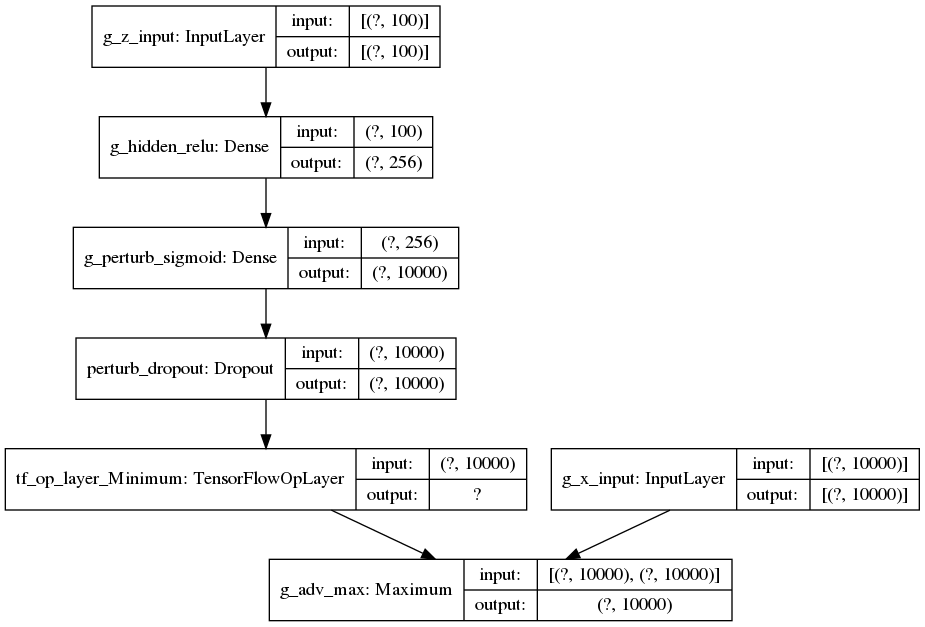

In [ ]:
plot_model(evadeGAN.generator, to_file="evadeGAN_gen.png", show_shapes=True,
           show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)
display(HTML("<h3>EvadeGAN Generator</h3><br />"))
Image("evadeGAN_gen.png")


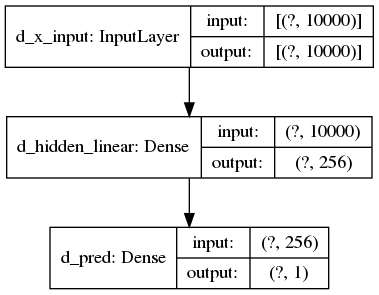

In [ ]:
plot_model(evadeGAN.discriminator, to_file="evadeGAN_dis.png", show_shapes=True,
           show_layer_names=True, rankdir="TB", expand_nested=True, dpi=96)
display(HTML("<h3>EvadeGAN Discriminator</h3><br />"))
Image("evadeGAN_dis.png")

### **4.1 EvadeGAN Training**

Training for 100 epochs.
**Best performance** achieved after **58 epochs**, with **evasion rate = 100%**
and **avg 13.8 changes per sample**.

Initial TPR on the training set: [1.0]
Initial TPR on the test set: [1.0]


>>>> New Best Results: Previous minTPR: [1.00000000] ==> New minTPR: [0.07157346] GAN Loss: [36.17675743]  <<<<
Epoch: 0
TPR Training : 0.06905188 | Avg # Changes: 6 ± SD(1.92) |  Change Quantiles (25%, 50%, 75%): [5, 6, 7] | Max 14
TPR Testing  : 0.07157346 | Avg # Changes: 6 ± SD(1.91) |  Change Quantiles (25%, 50%, 75%): [5, 6, 7] | Max: 14



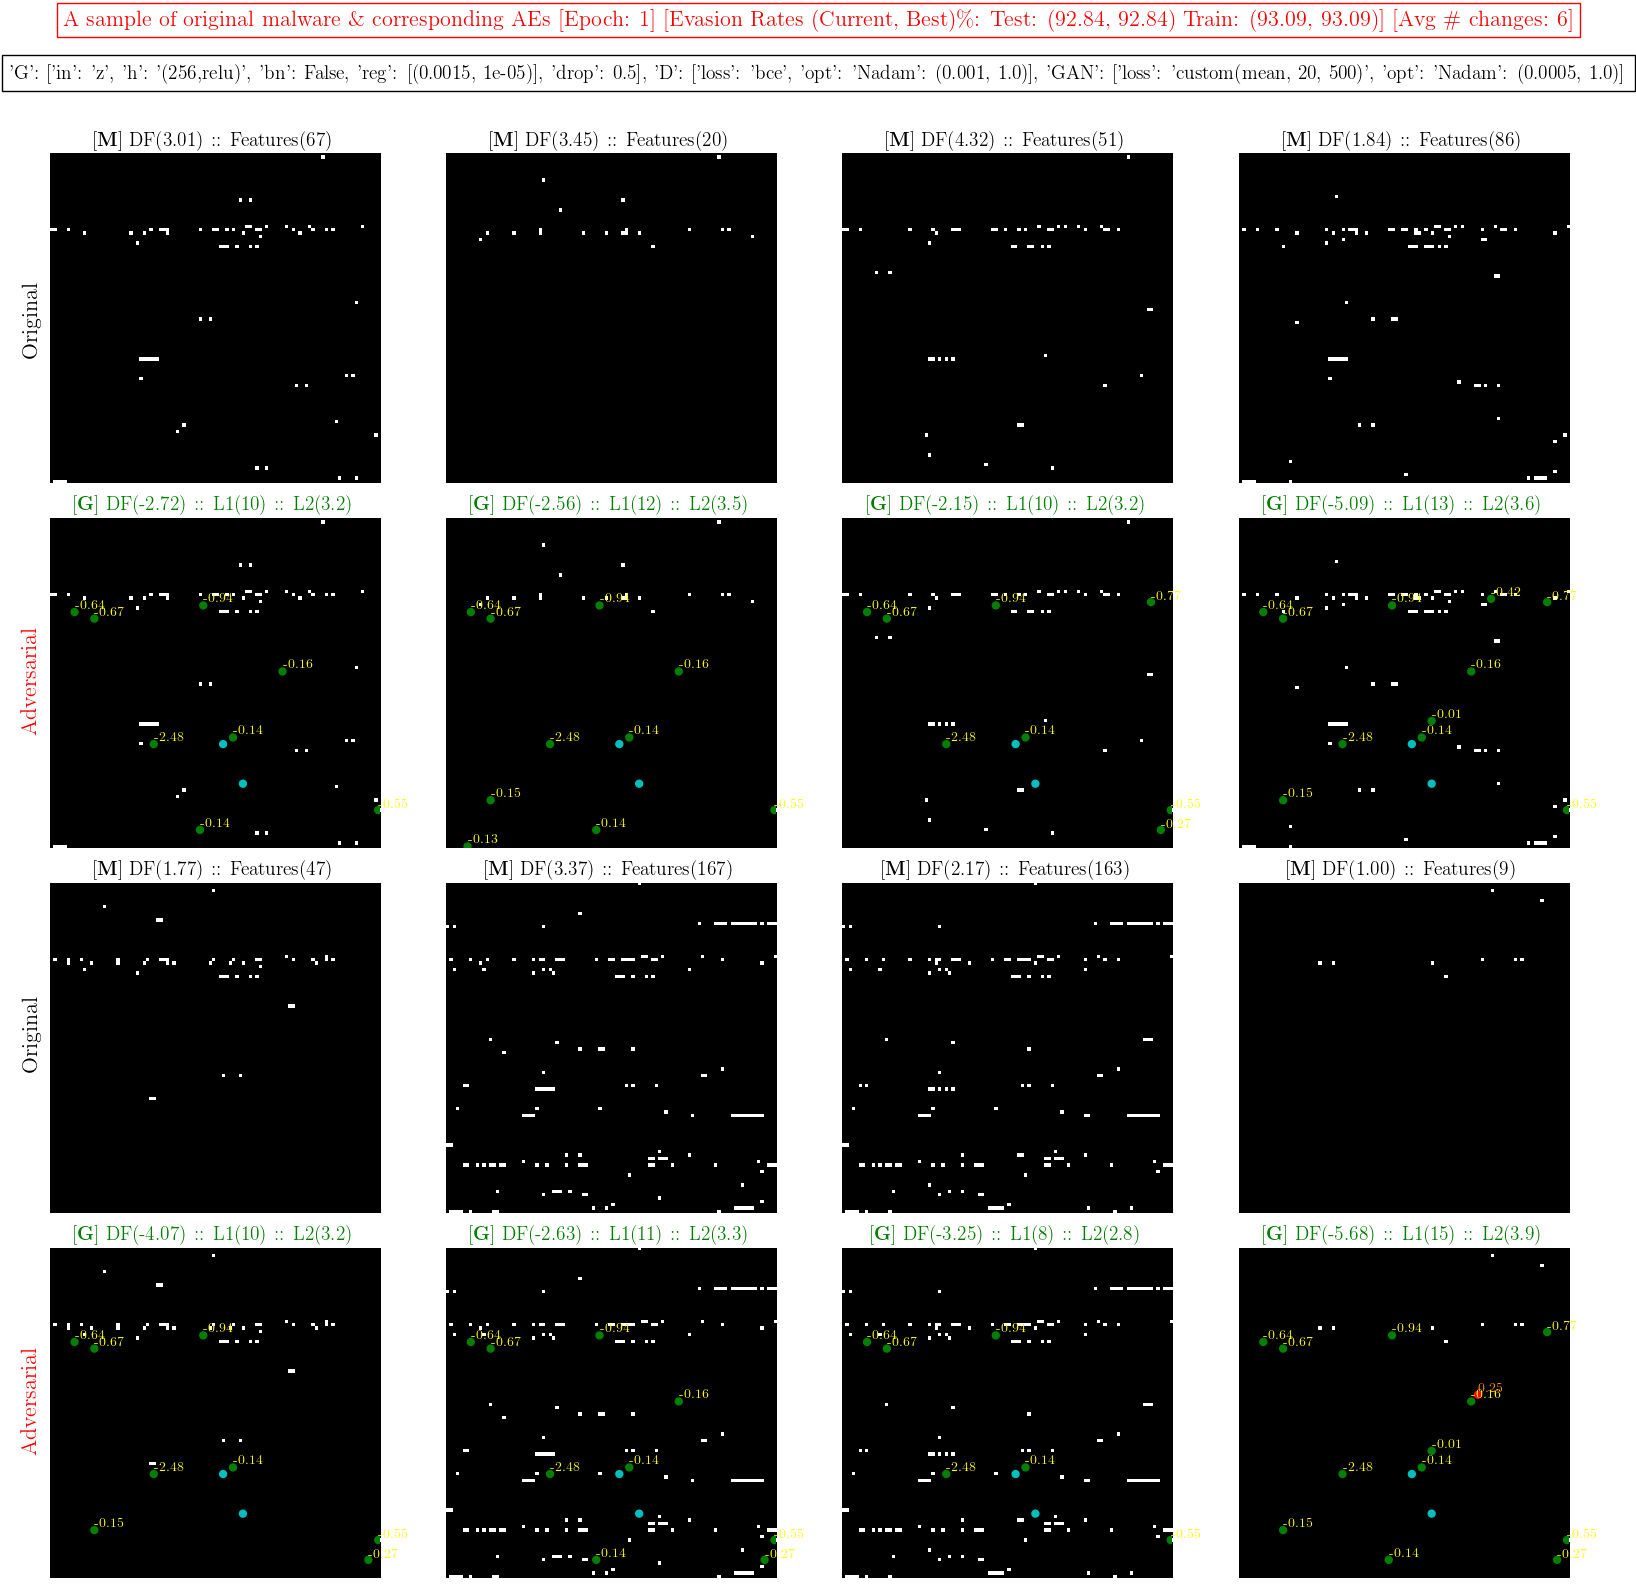


>>>> New Best Results: Previous minTPR: [0.07157346] ==> New minTPR: [0.00579542] GAN Loss: [0.91537372]  <<<<
Epoch: 1
TPR Training : 0.00417412 | Avg # Changes: 14 ± SD(1.44) |  Change Quantiles (25%, 50%, 75%): [13, 14, 15] | Max 20
TPR Testing  : 0.00579542 | Avg # Changes: 14 ± SD(1.45) |  Change Quantiles (25%, 50%, 75%): [13, 14, 15] | Max: 20



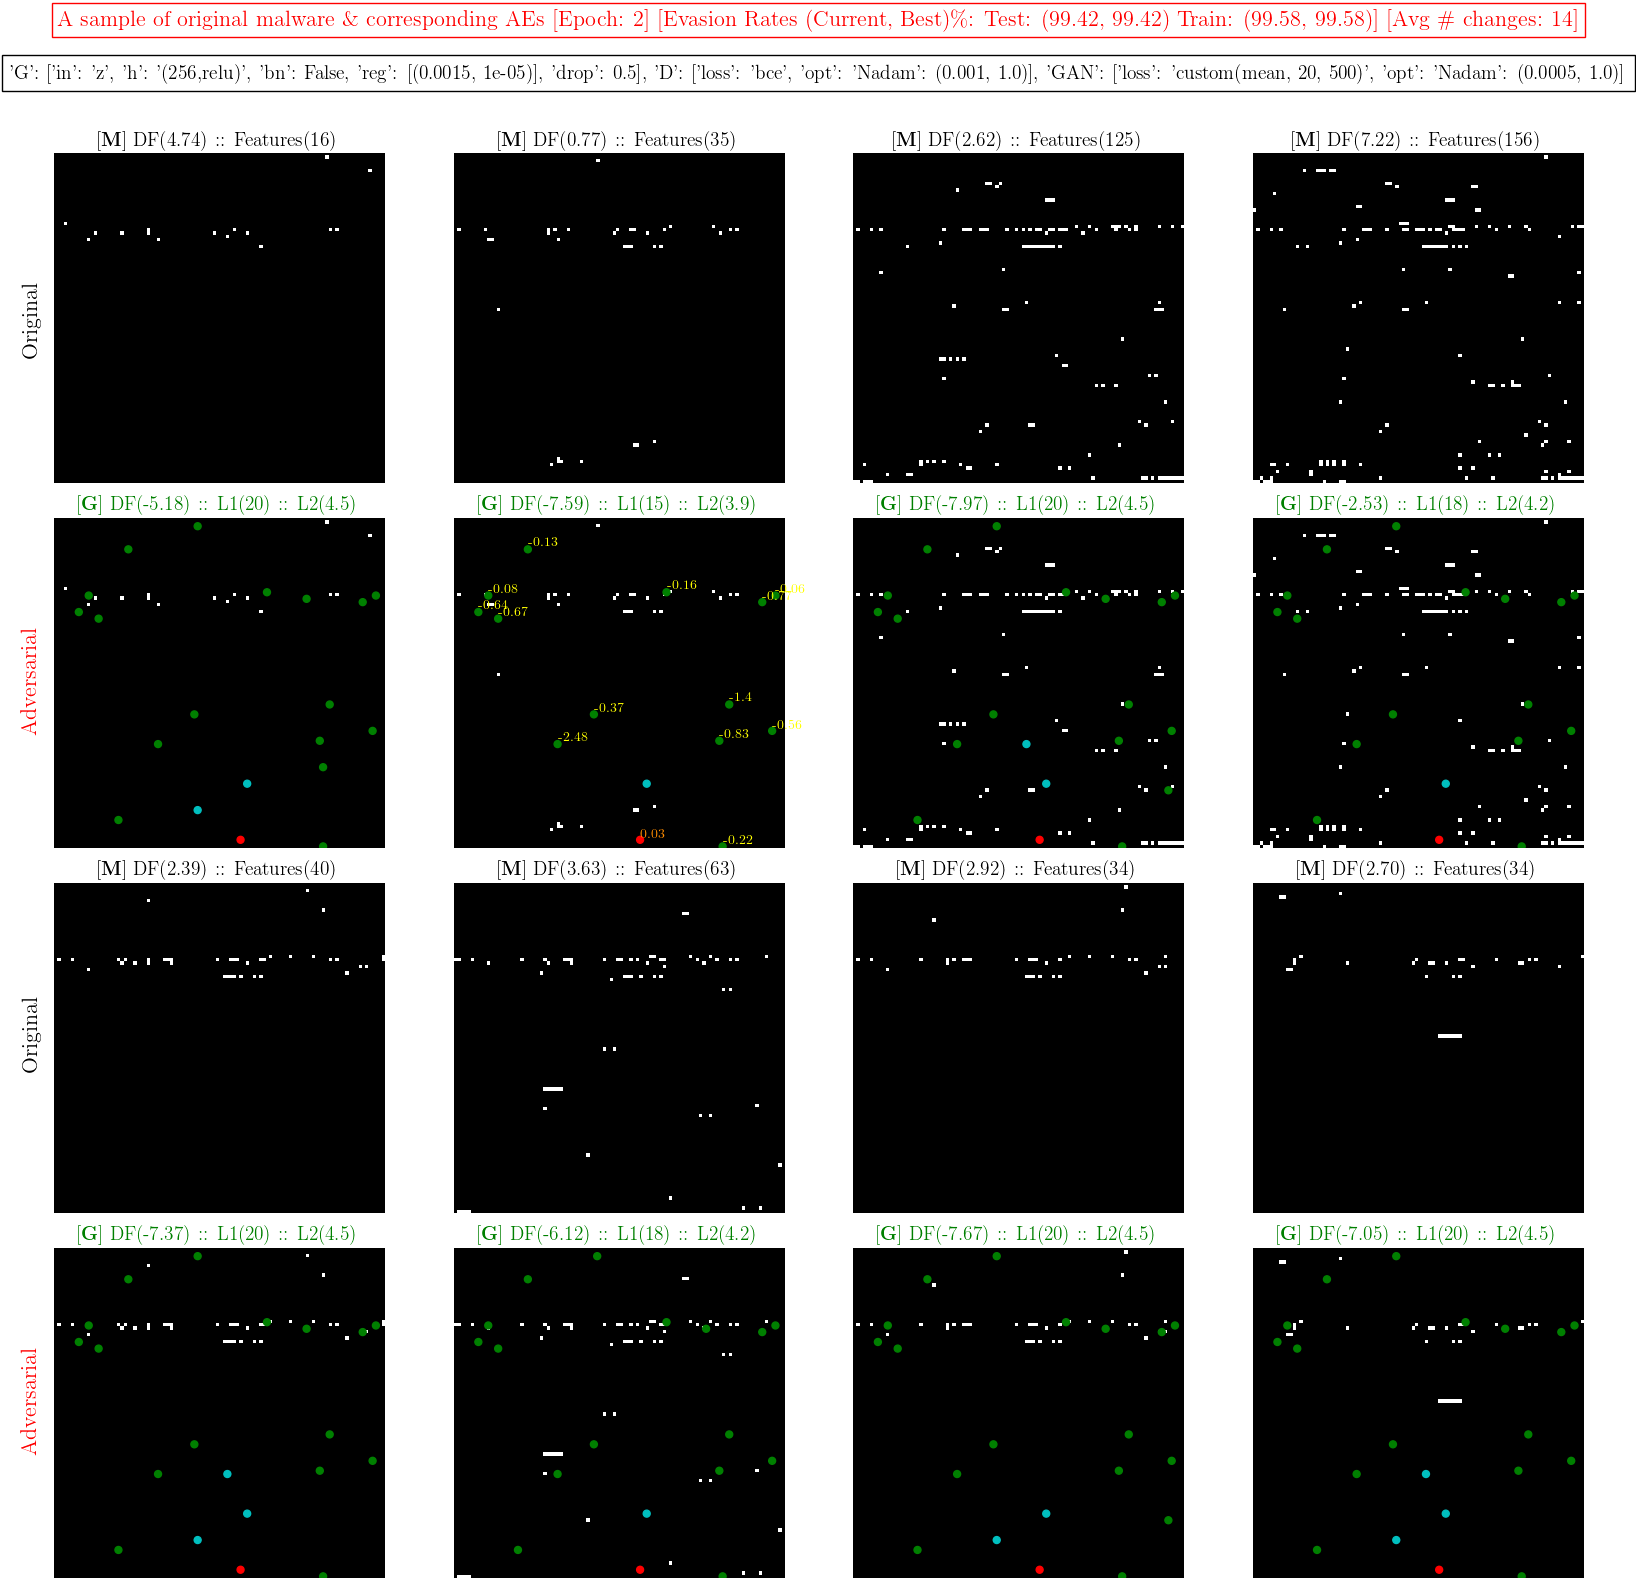


>>>> New Best Results: Previous minTPR: [0.00579542] ==> New minTPR: [0.00000000] GAN Loss: [0.59476745]  <<<<
Epoch: 2
TPR Training : 0.00000000 | Avg # Changes: 52 ± SD(2.17) |  Change Quantiles (25%, 50%, 75%): [50, 52, 53] | Max 60
TPR Testing  : 0.00000000 | Avg # Changes: 52 ± SD(2.15) |  Change Quantiles (25%, 50%, 75%): [50, 52, 53] | Max: 59



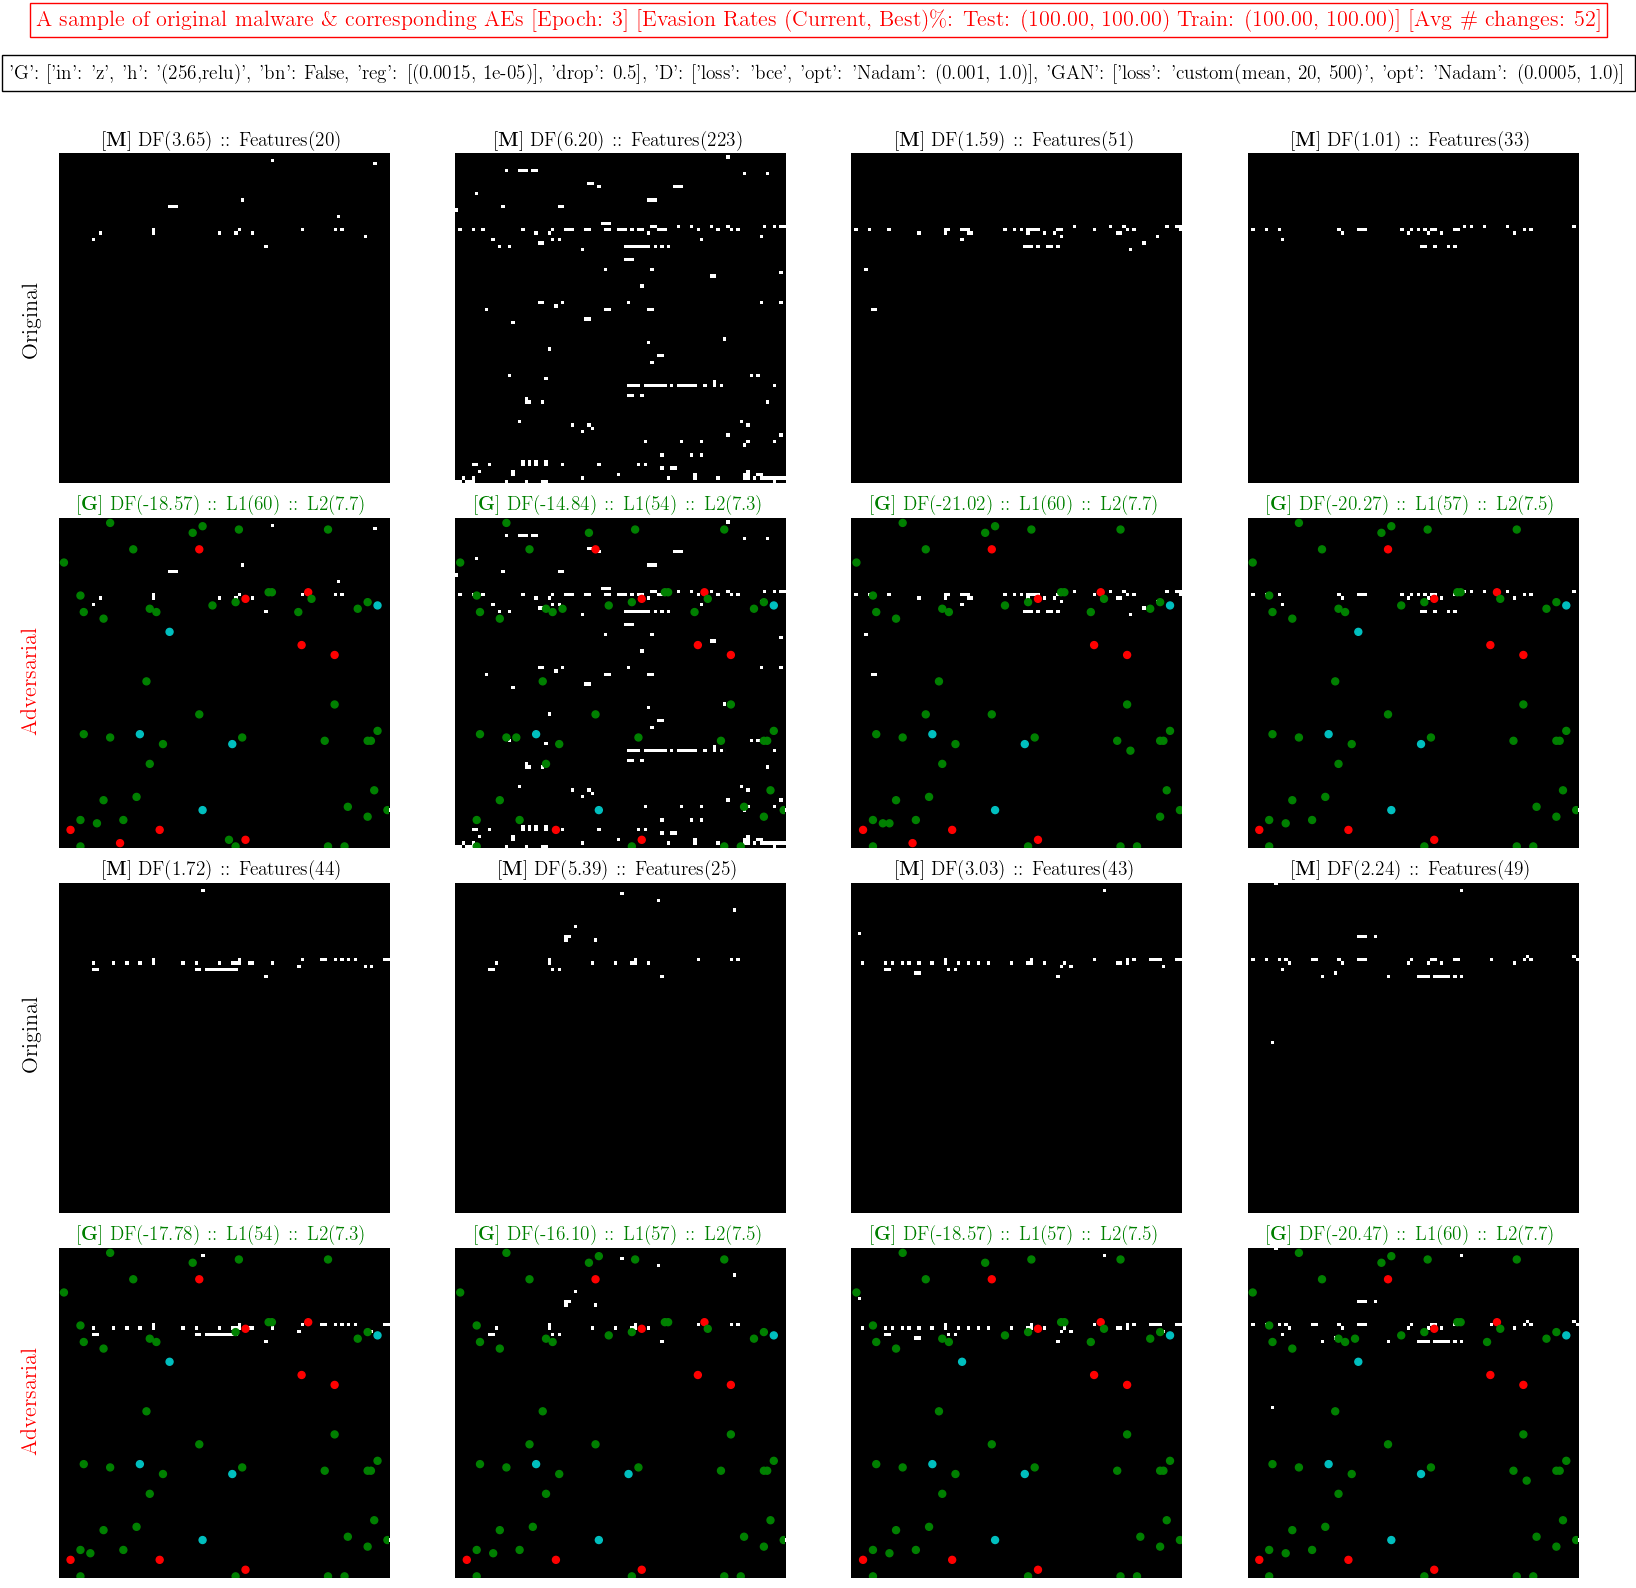


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [2] epochs, with avg 51.7 and max 59.0 changes per sample (on the test set) ... GAN Loss: [0.59476745]
######################################################################################################################################################


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [0.25689727]  <<<<
Epoch: 9
TPR Training : 0.00000000 | Avg # Changes: 36 ± SD(1.09) |  Change Quantiles (25%, 50%, 75%): [35, 36, 36] | Max 38
TPR Testing  : 0.00000000 | Avg # Changes: 36 ± SD(1.09) |  Change Quantiles (25%, 50%, 75%): [35, 36, 36] | Max: 38



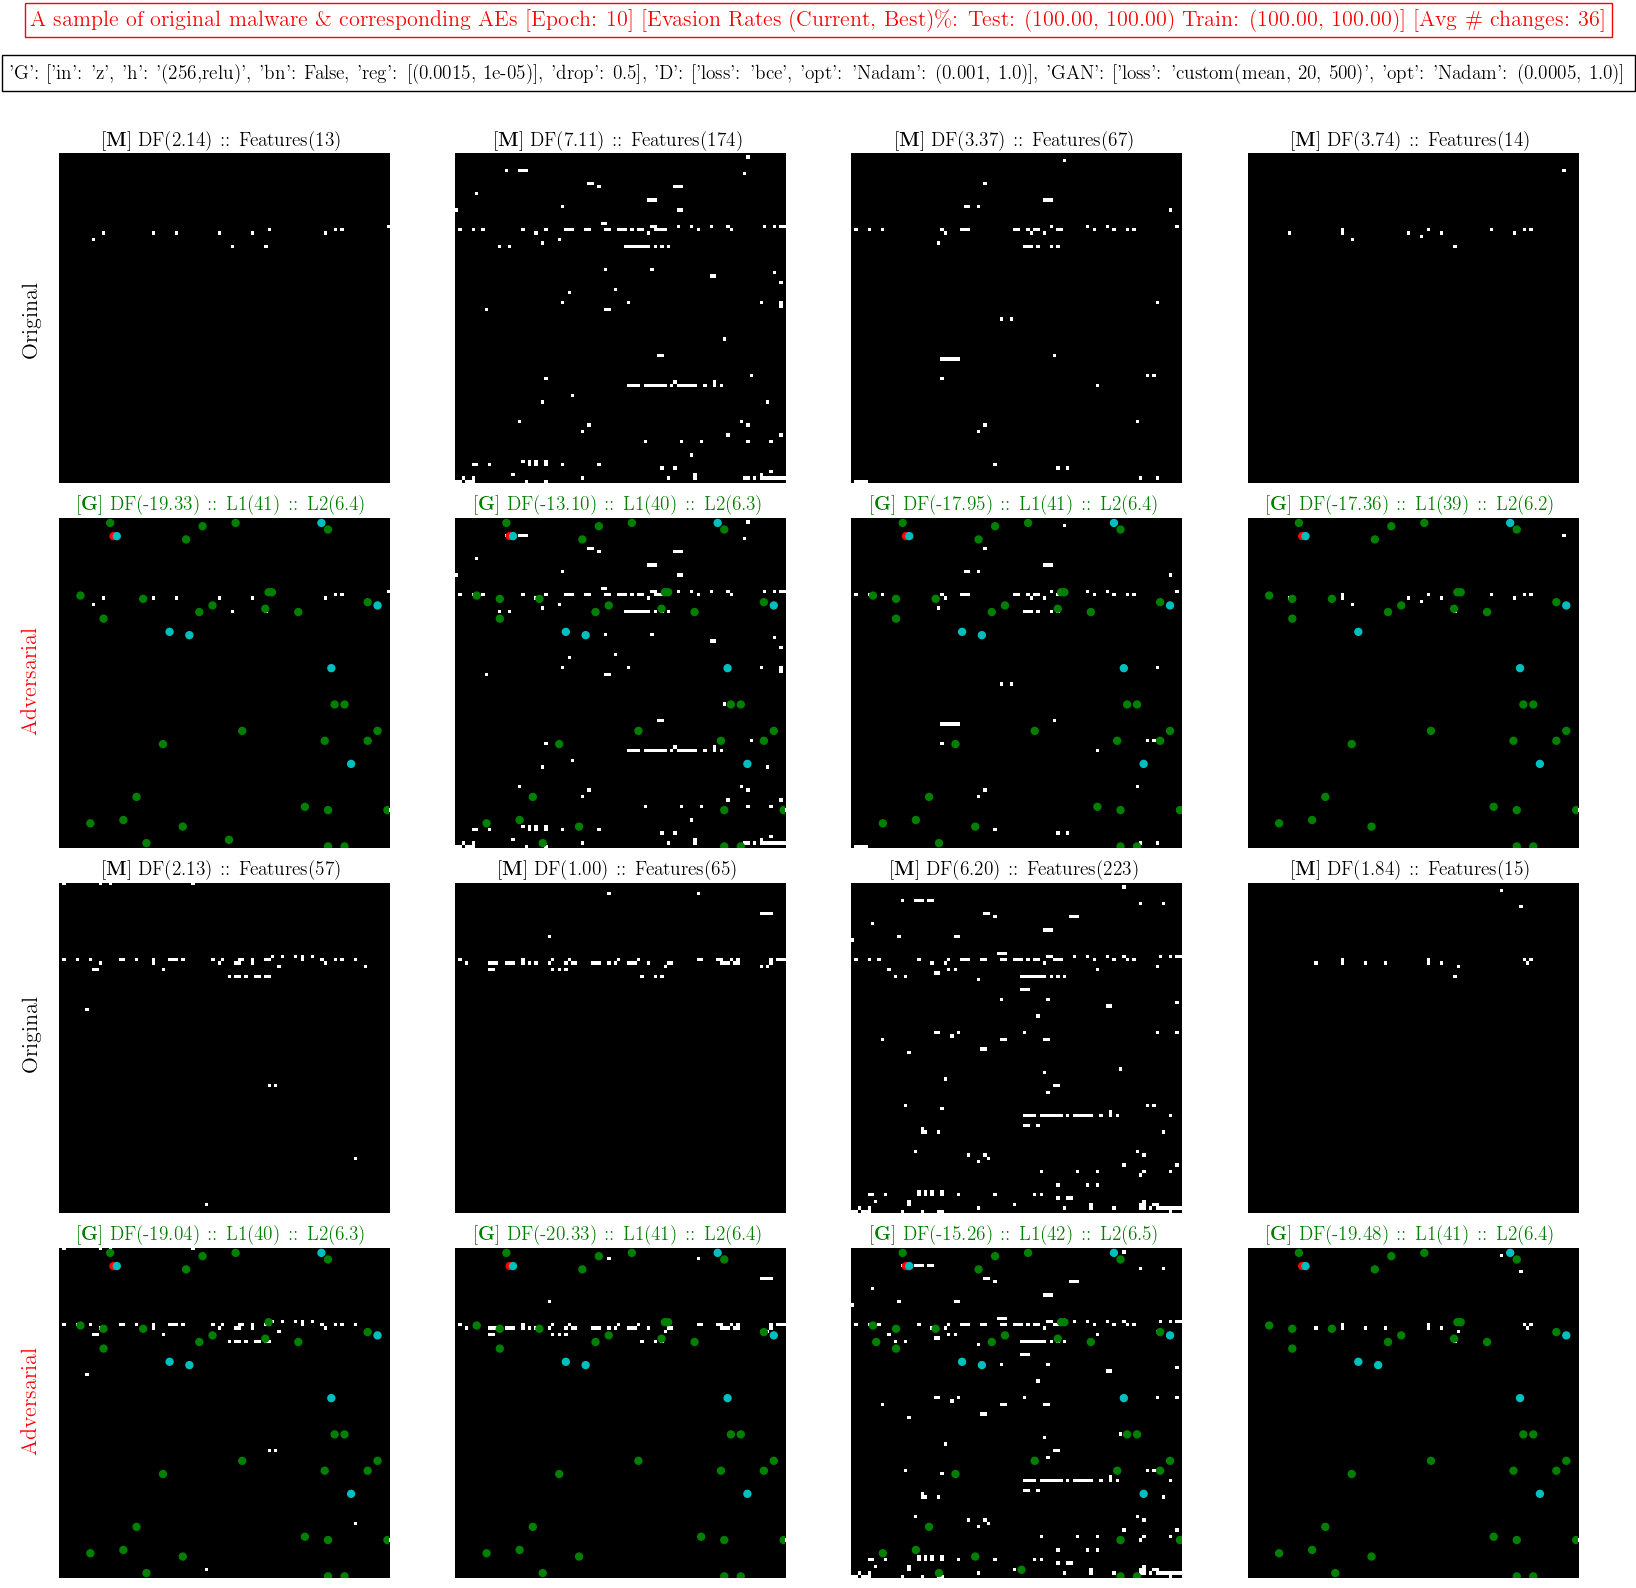


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [9] epochs, with avg 35.9 and max 38.0 changes per sample (on the test set) ... GAN Loss: [0.25689727]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [12] epochs, with avg 37.2 and max 40.0 changes per sample (on the test set) ... GAN Loss: [0.39846855]
######################################################################################################################################################



>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN L

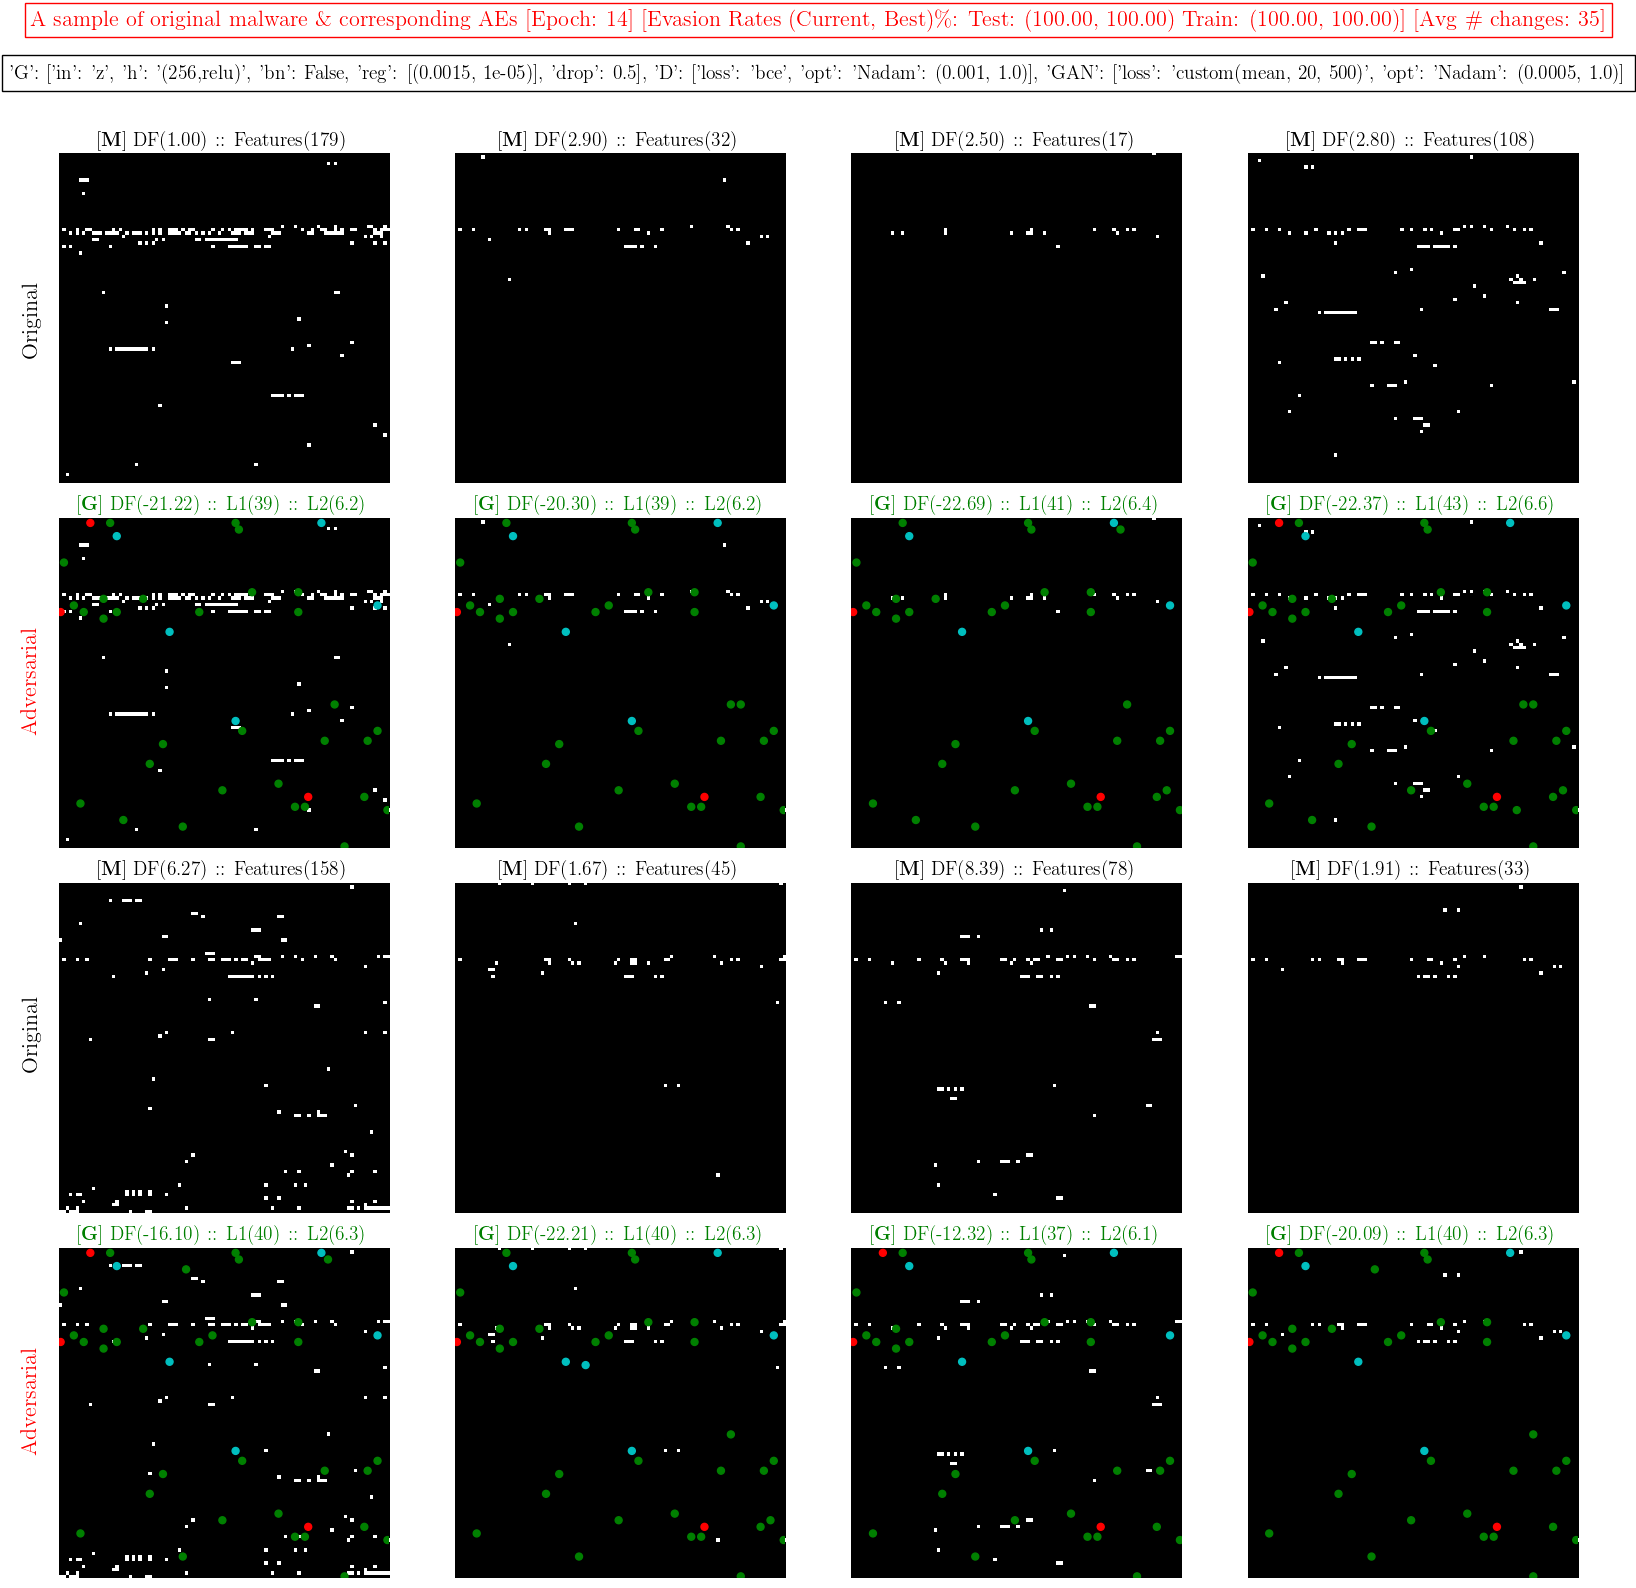


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [13] epochs, with avg 34.6 and max 42.0 changes per sample (on the test set) ... GAN Loss: [0.49209889]
######################################################################################################################################################


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [20] epochs, with avg 40.6 and max 43.0 changes per sample (on the test set) ... GAN Loss: [0.14901401]
######################################################################################################################################################



*** Checking progress *** GAN Loss: [0.22025826] ***
Epoch: 23
TPR Training : 0.000954

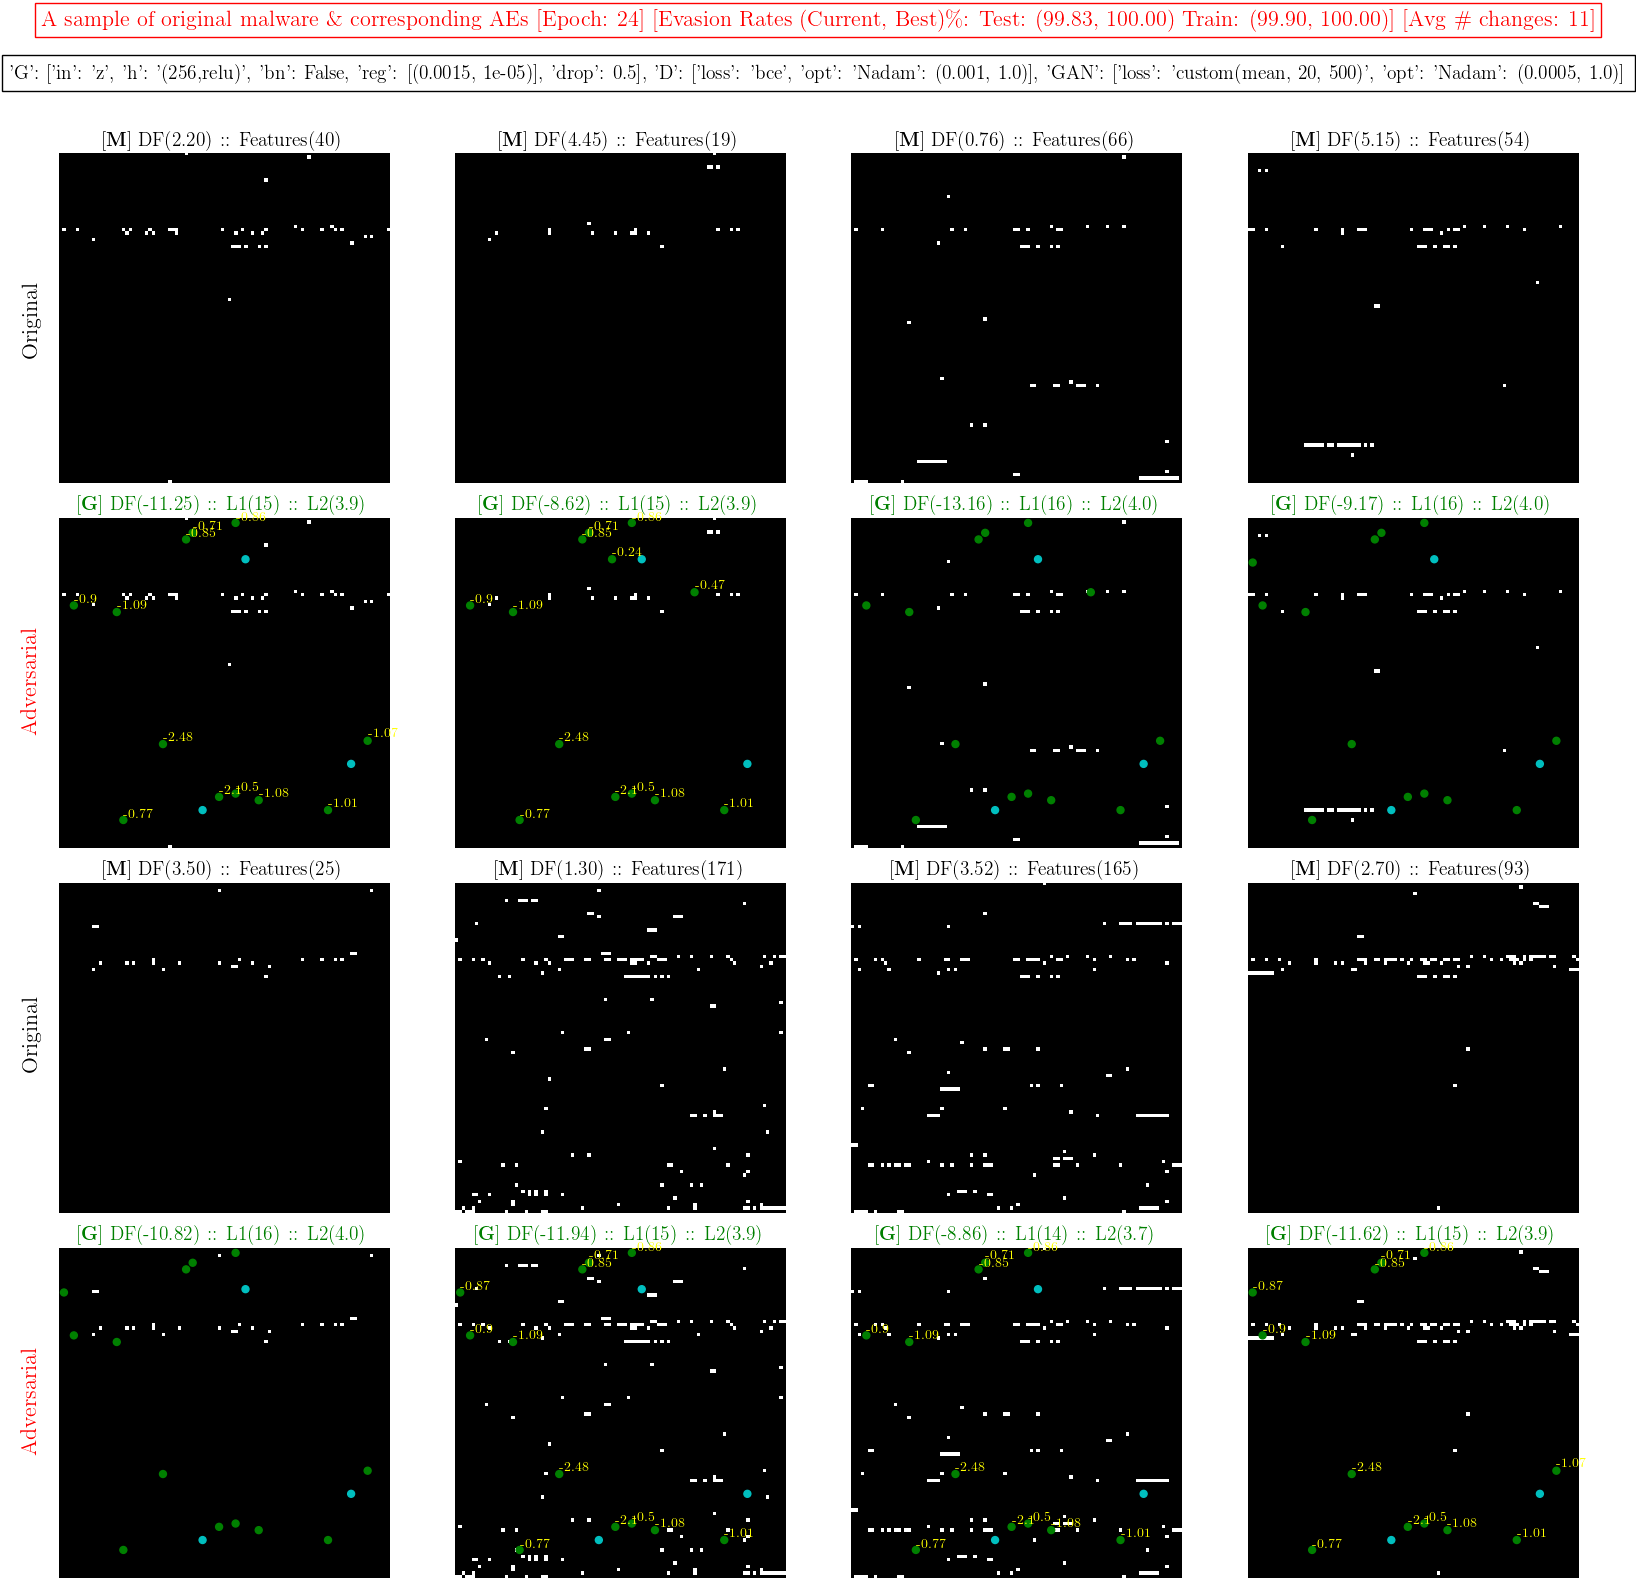


*** Checking progress *** GAN Loss: [0.10821535] ***
Epoch: 33
TPR Training : 0.00011926 | Avg # Changes: 18 ± SD(3.12) |  Change Quantiles (25%, 50%, 75%): [16, 18, 20] | Max 28
TPR Testing  : 0.00028977 | Avg # Changes: 18 ± SD(3.10) |  Change Quantiles (25%, 50%, 75%): [16, 18, 21] | Max: 27



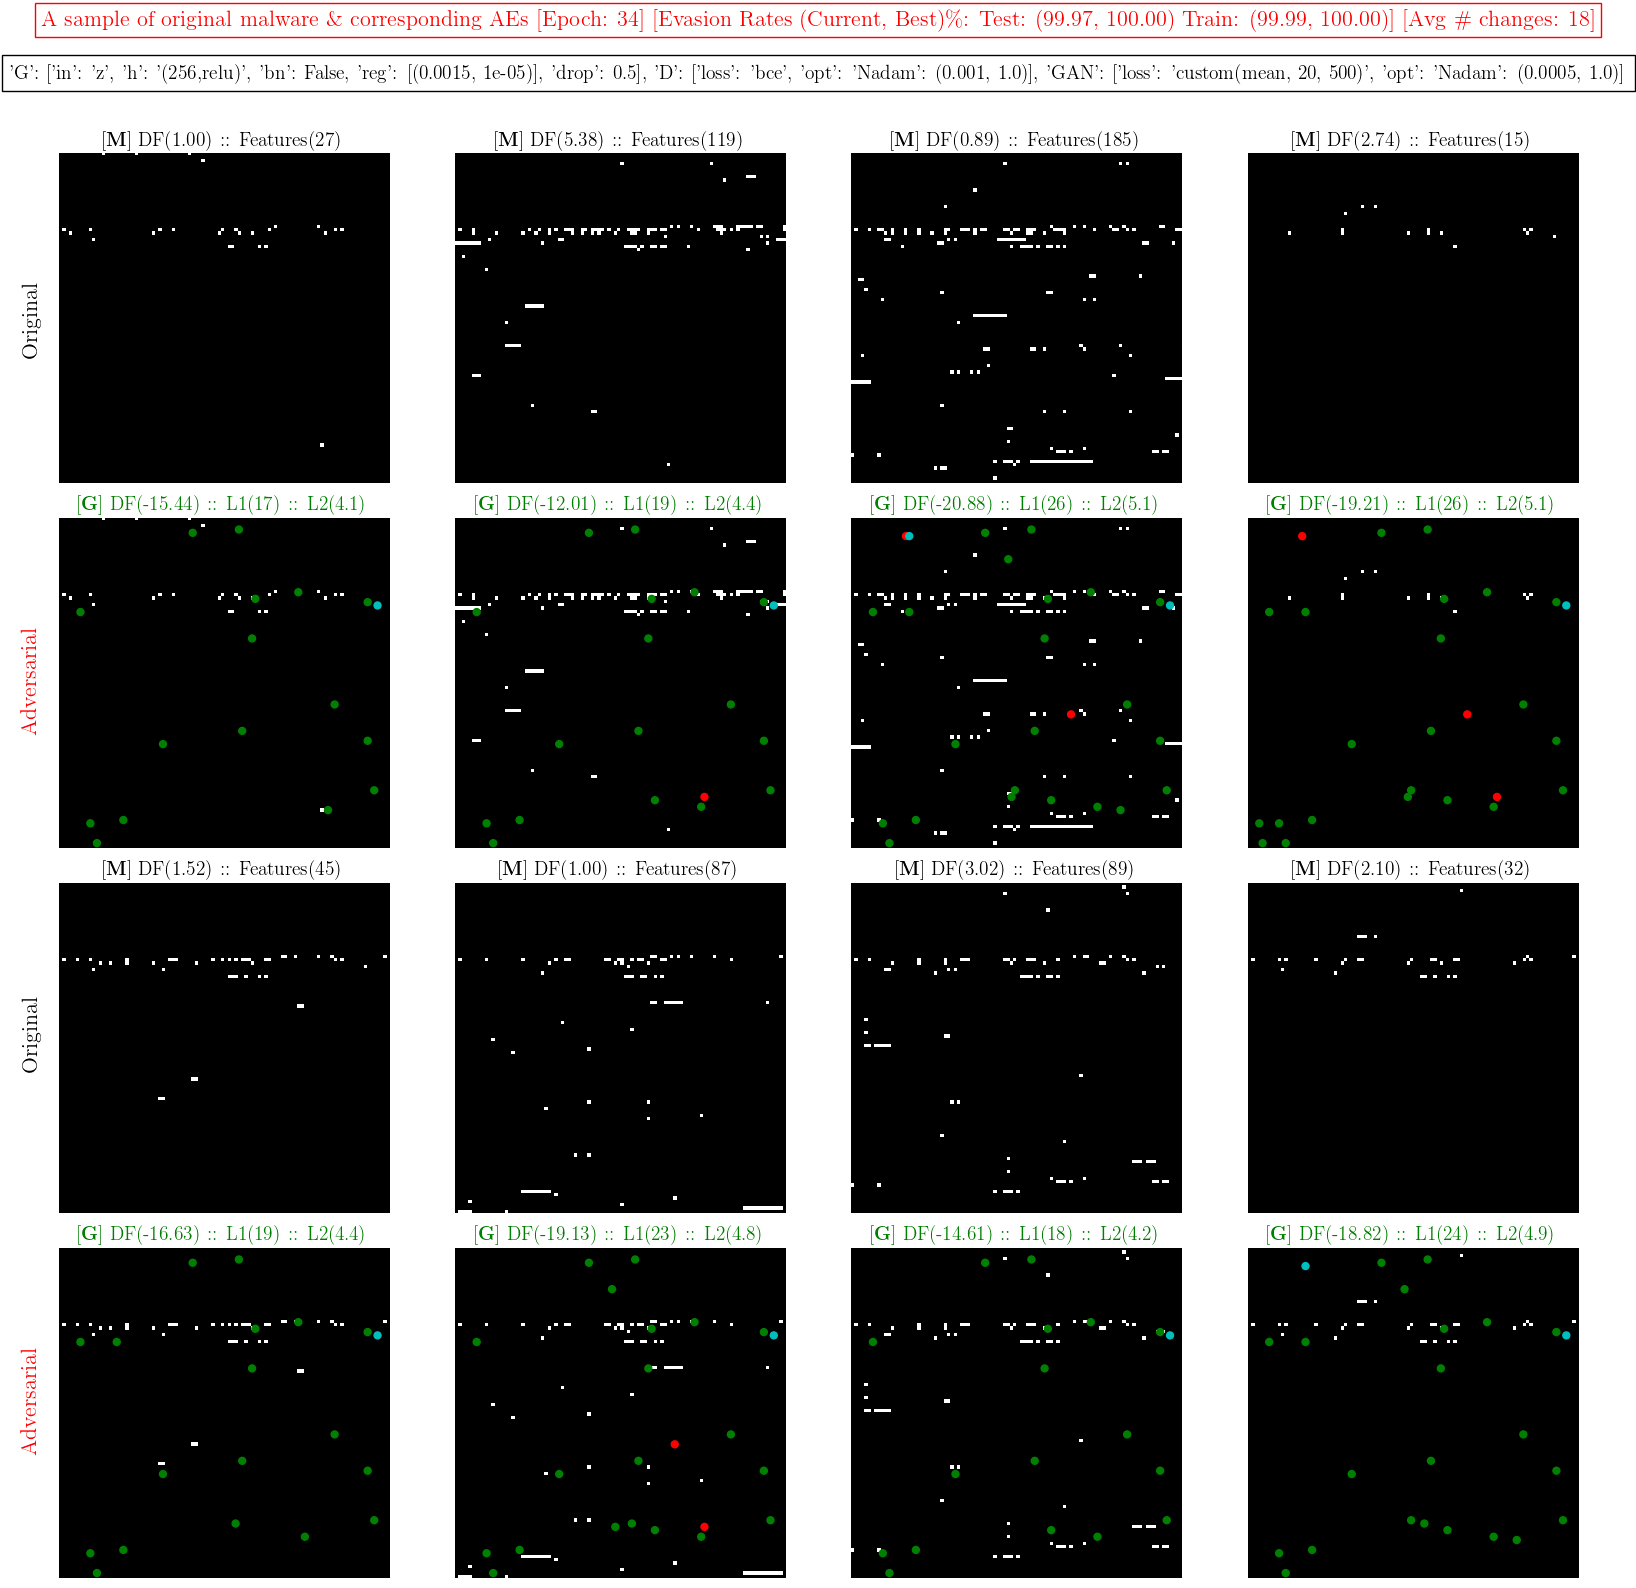


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [0.11356529]  <<<<
Epoch: 36
TPR Training : 0.00000000 | Avg # Changes: 24 ± SD(1.49) |  Change Quantiles (25%, 50%, 75%): [23, 24, 25] | Max 29
TPR Testing  : 0.00000000 | Avg # Changes: 24 ± SD(1.51) |  Change Quantiles (25%, 50%, 75%): [23, 24, 25] | Max: 29



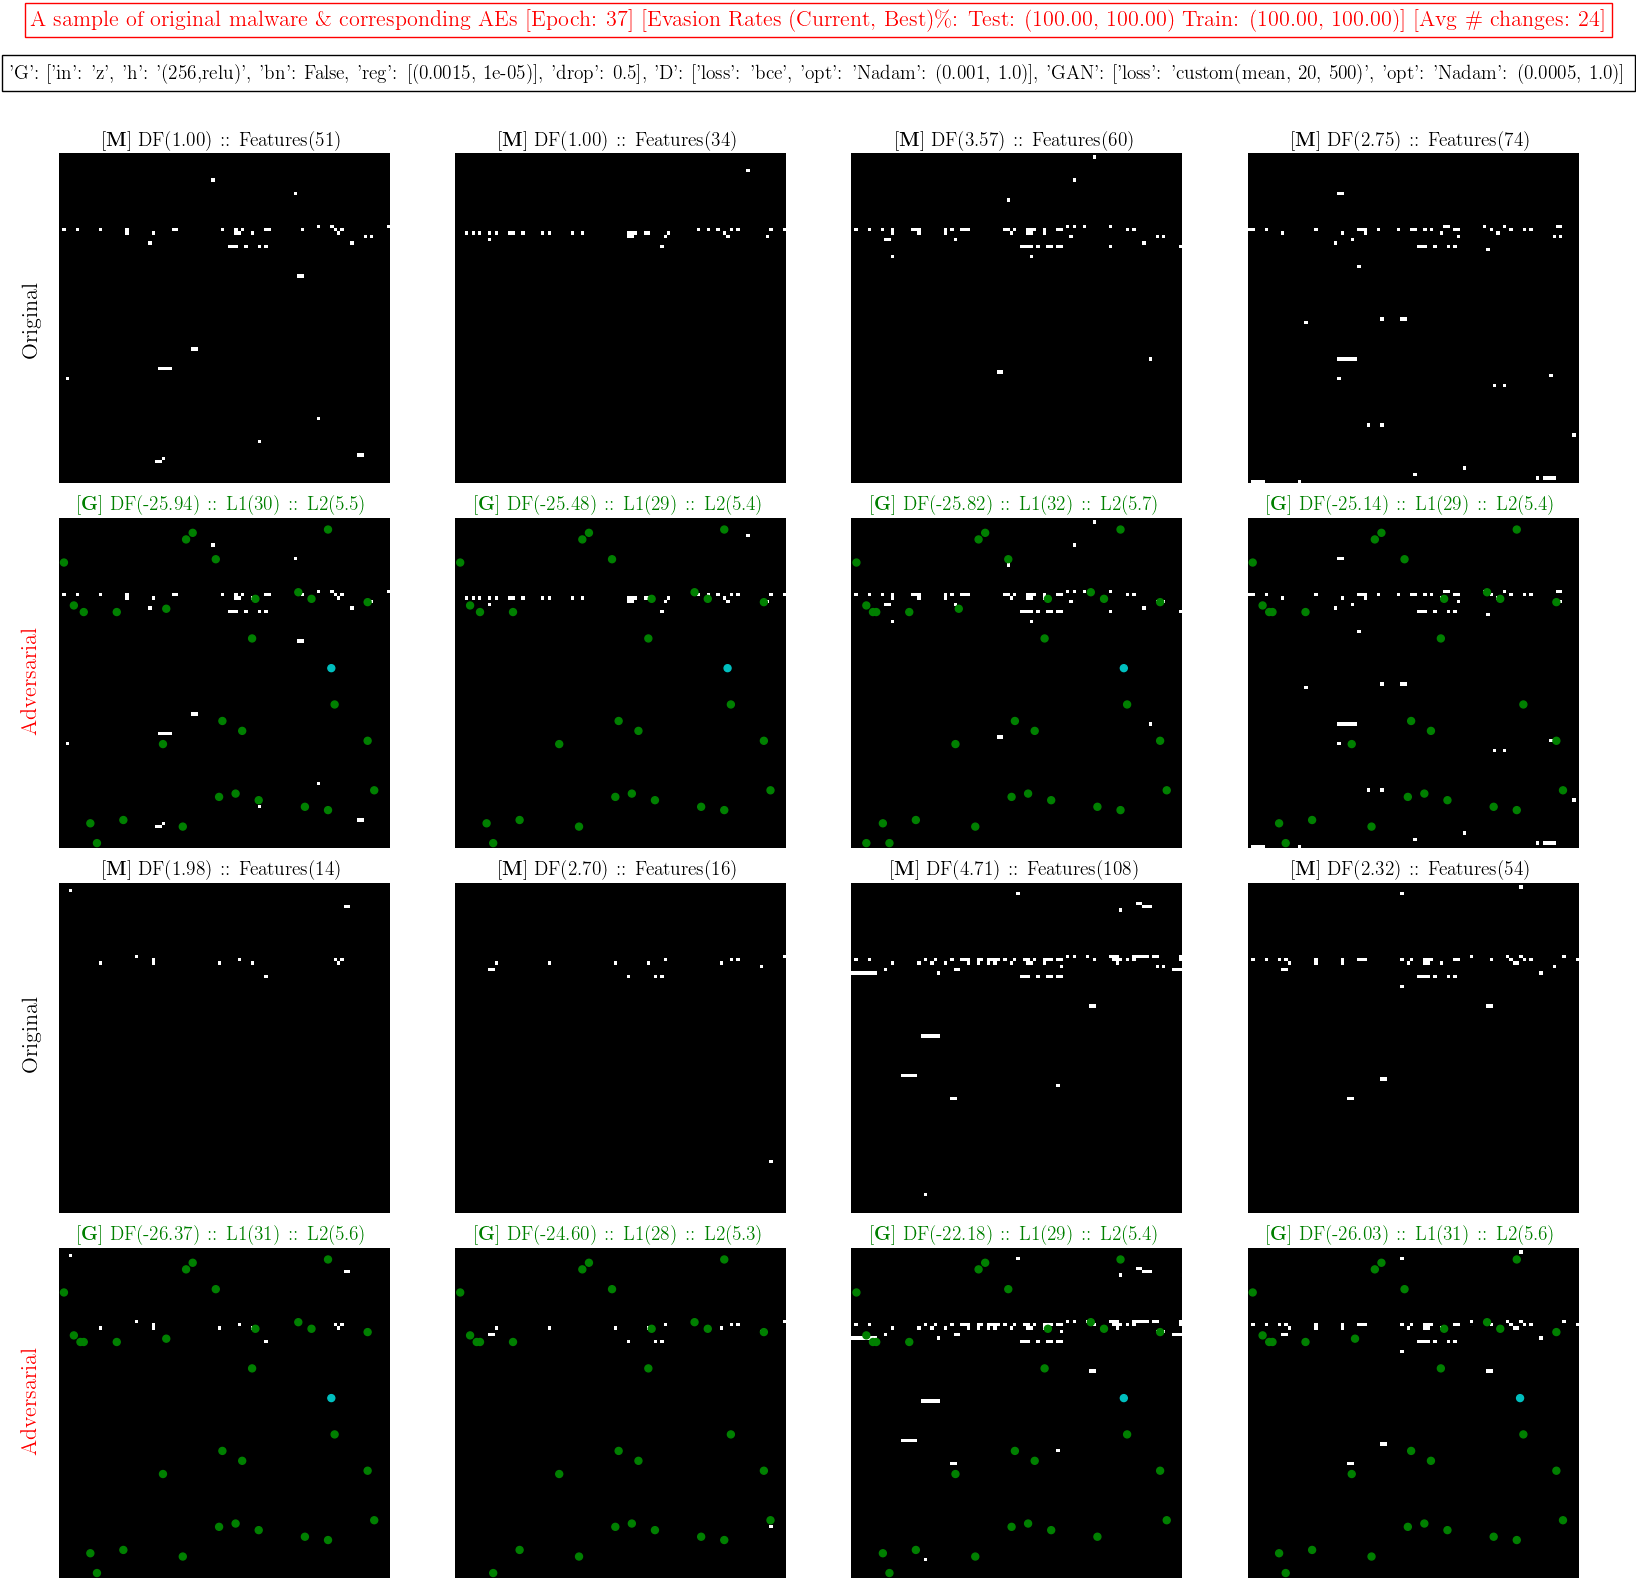


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [36] epochs, with avg 24.2 and max 29.0 changes per sample (on the test set) ... GAN Loss: [0.11356529]
######################################################################################################################################################


*** Checking progress *** GAN Loss: [0.10411348] ***
Epoch: 46
TPR Training : 0.00023852 | Avg # Changes: 13 ± SD(1.34) |  Change Quantiles (25%, 50%, 75%): [12, 13, 13] | Max 16
TPR Testing  : 0.00028977 | Avg # Changes: 13 ± SD(1.36) |  Change Quantiles (25%, 50%, 75%): [12, 13, 13] | Max: 16



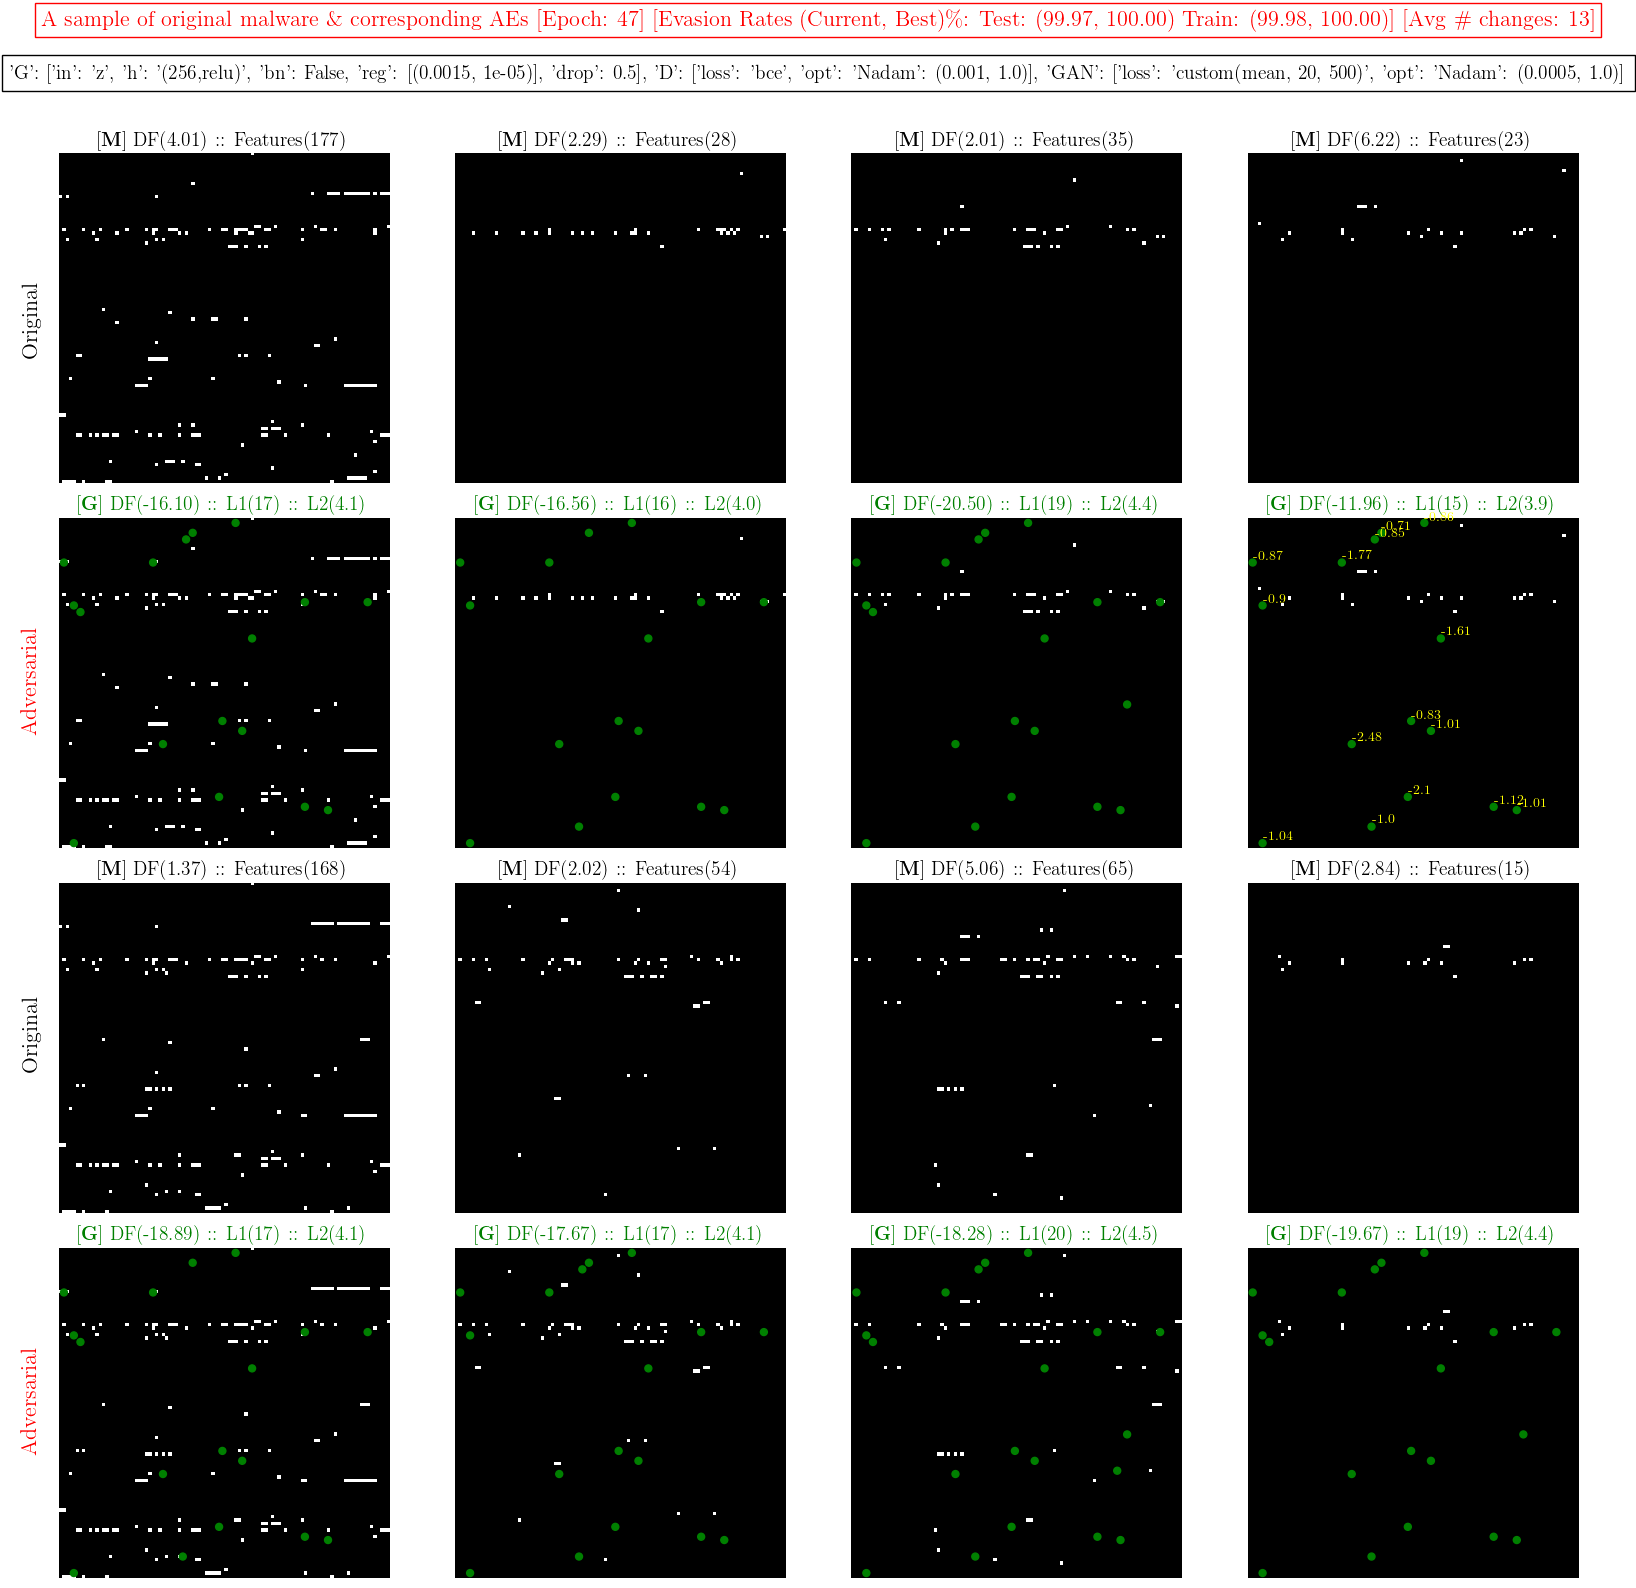


>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [0.06373635]  <<<<
Epoch: 47
TPR Training : 0.00000000 | Avg # Changes: 15 ± SD(0.86) |  Change Quantiles (25%, 50%, 75%): [15, 15, 15] | Max 19
TPR Testing  : 0.00000000 | Avg # Changes: 15 ± SD(0.90) |  Change Quantiles (25%, 50%, 75%): [15, 15, 15] | Max: 19



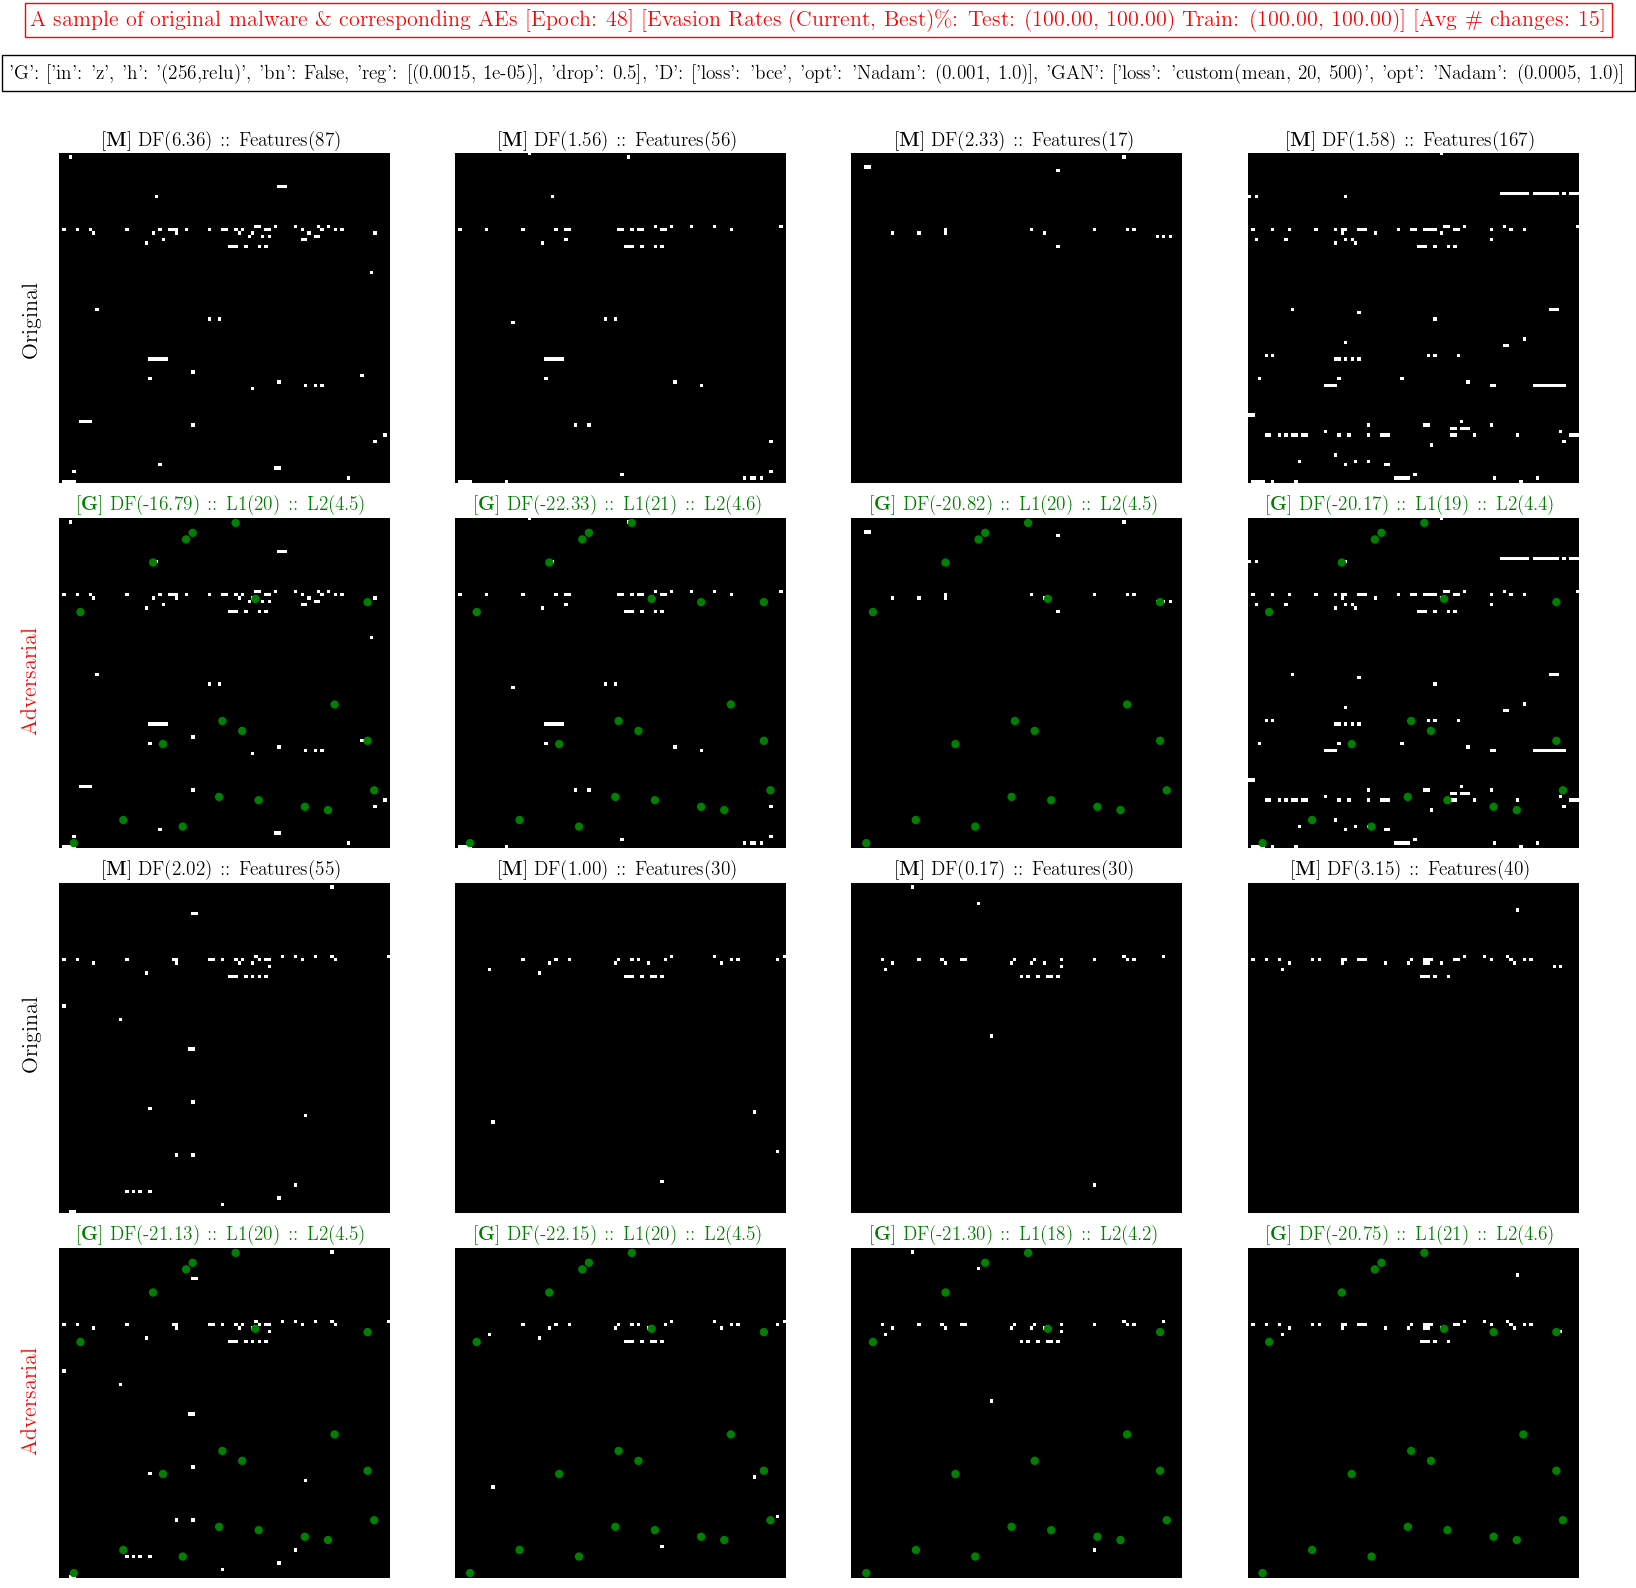


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [47] epochs, with avg 14.9 and max 19.0 changes per sample (on the test set) ... GAN Loss: [0.06373635]
######################################################################################################################################################

Training CONVERGED. Target Evasion Rate achieved within max changes...TRAINING ENDS HERE #

>>>> New Best Results: Previous minTPR: [0.00000000] ==> New minTPR: [0.00000000] GAN Loss: [0.03606044]  <<<<
Epoch: 57
TPR Training : 0.00000000 | Avg # Changes: 14 ± SD(1.36) |  Change Quantiles (25%, 50%, 75%): [13, 14, 15] | Max 16
TPR Testing  : 0.00000000 | Avg # Changes: 14 ± SD(1.31) |  Change Quantiles (25%, 50%, 75%): [13, 14, 15] | Max: 17



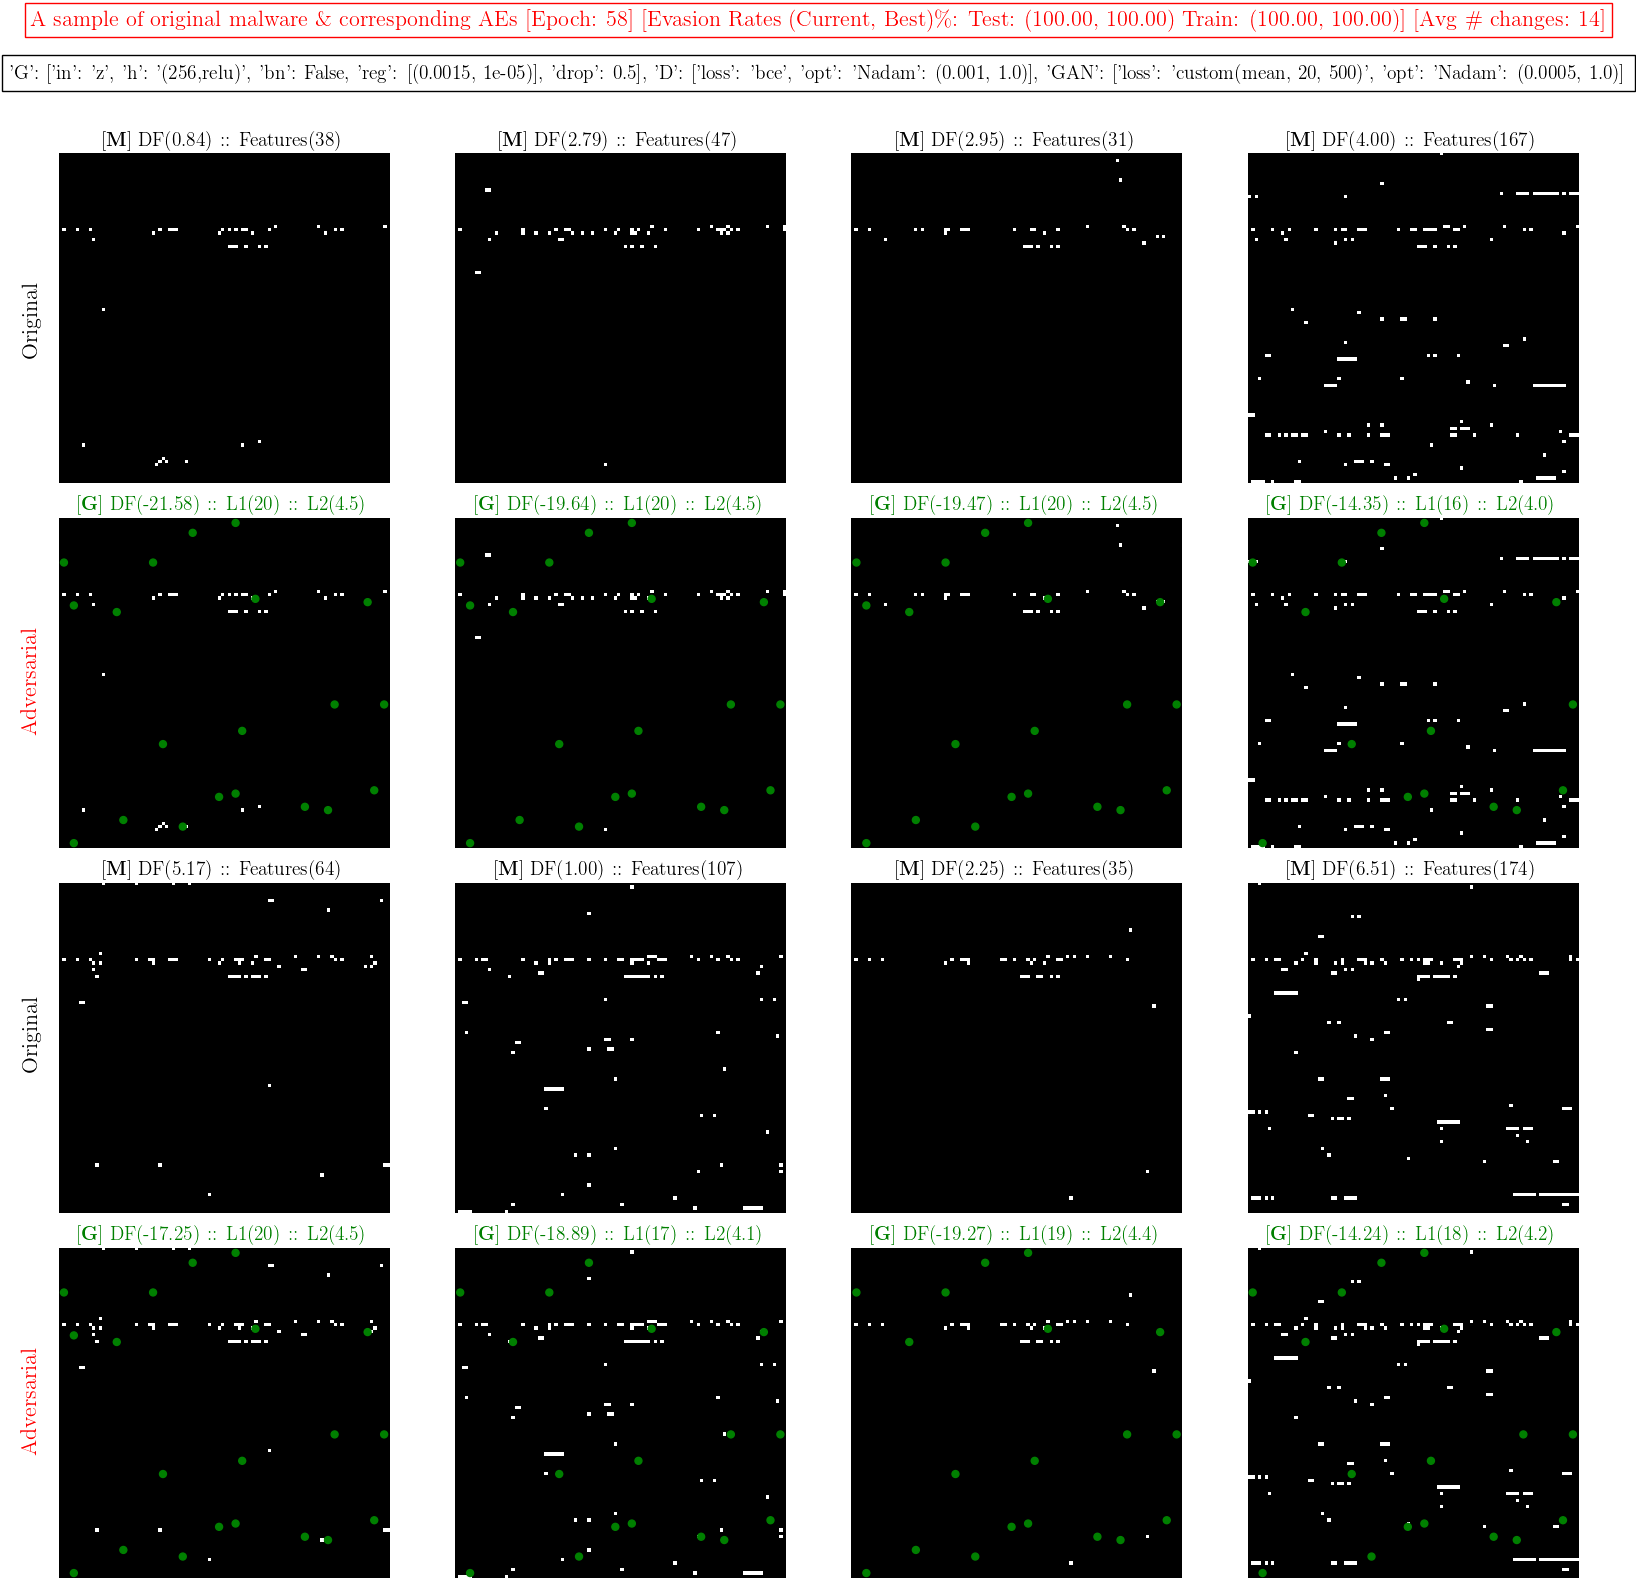


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [57] epochs, with avg 13.8 and max 17.0 changes per sample (on the test set) ... GAN Loss: [0.03606044]
######################################################################################################################################################

Training CONVERGED. Target Evasion Rate achieved within max changes...TRAINING ENDS HERE #

######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [60] epochs, with avg 19.6 and max 26.0 changes per sample (on the test set) ... GAN Loss: [0.04743103]
#####################################################################################################################################################

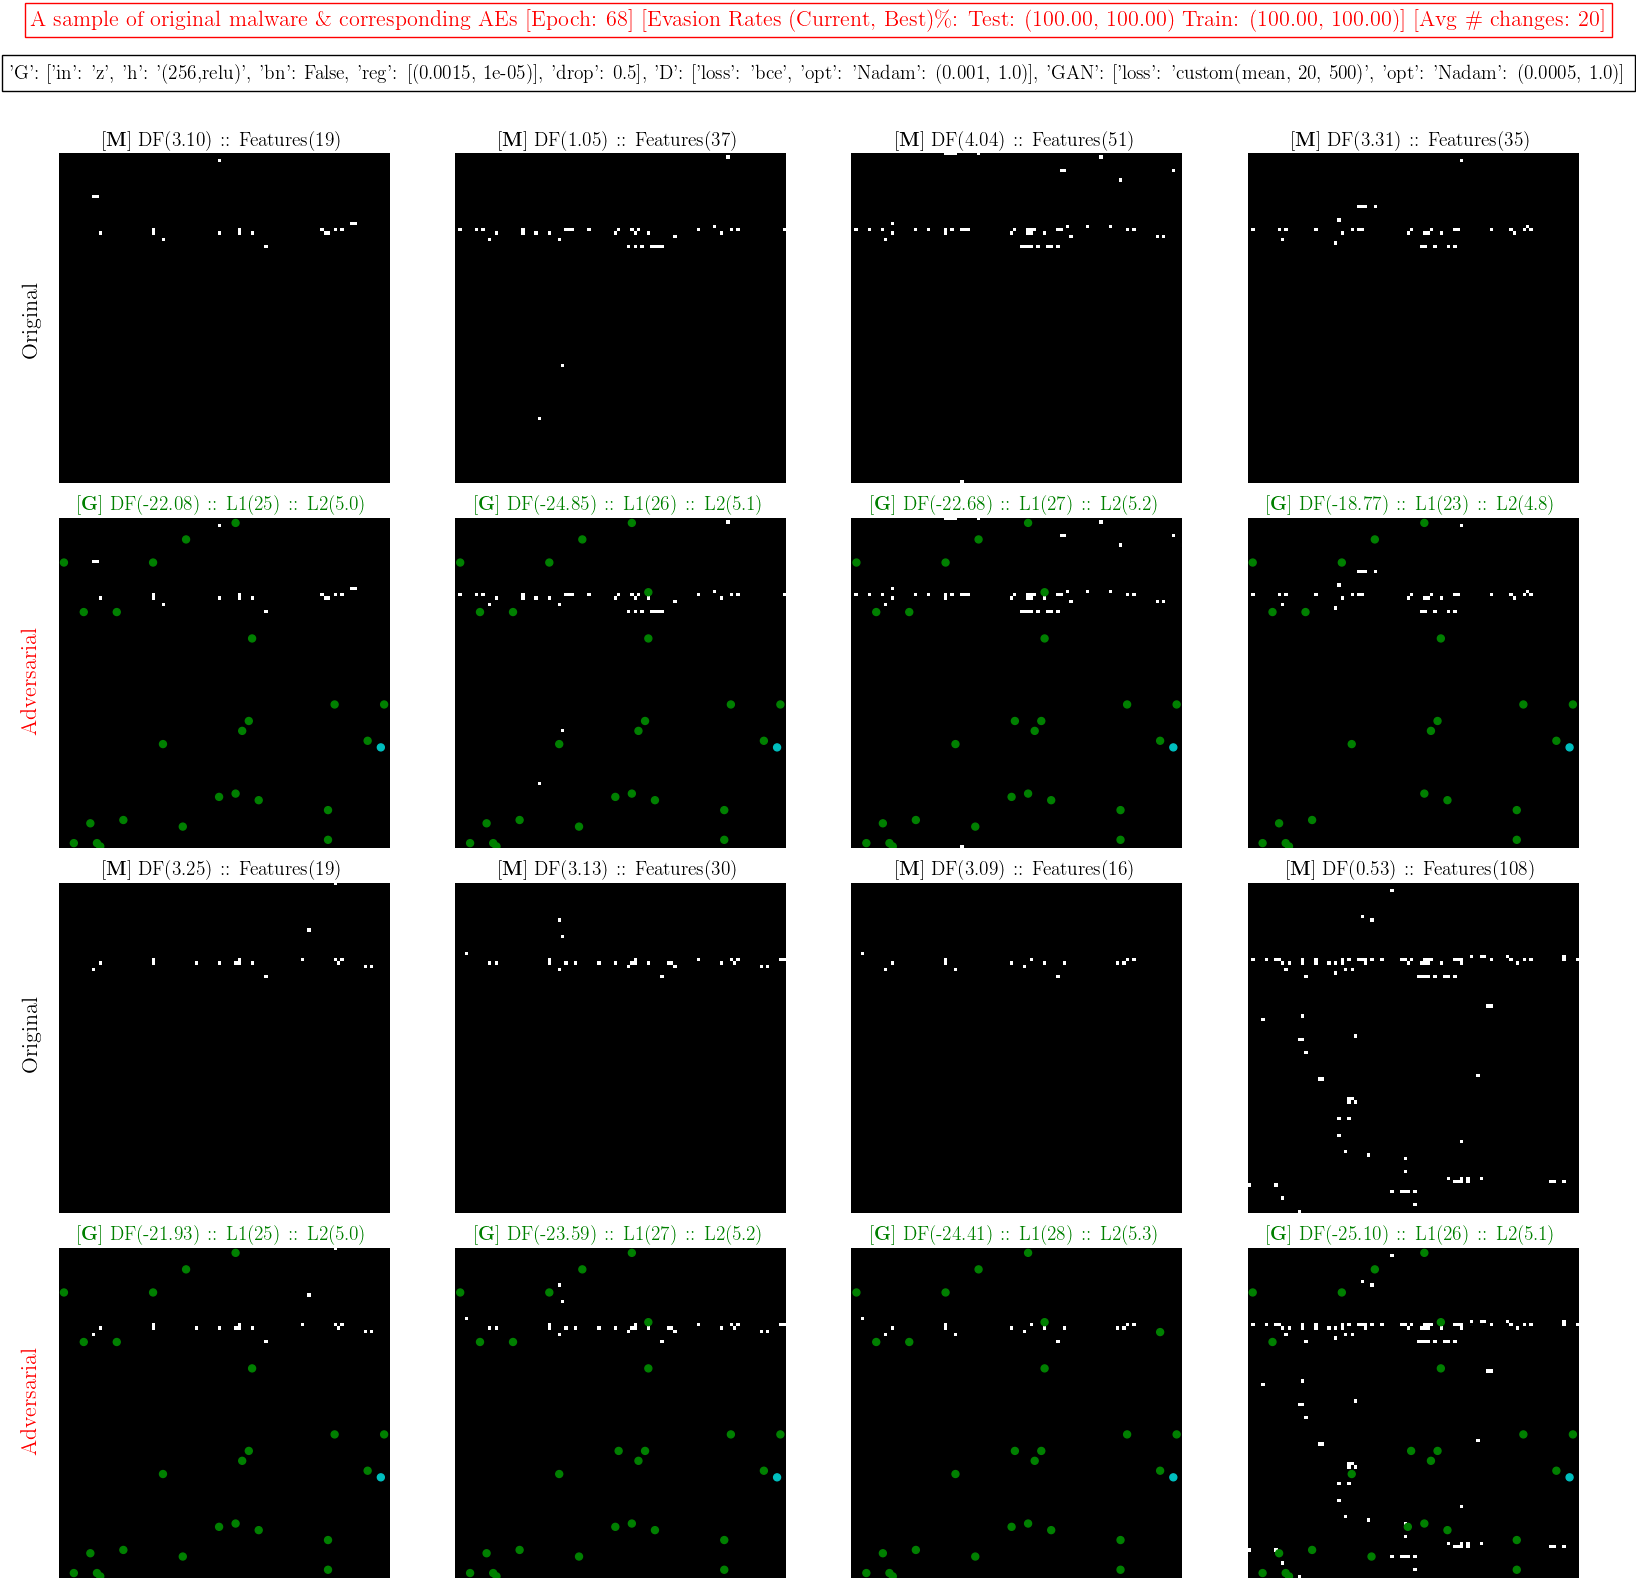


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [69] epochs, with avg 24.0 and max 28.0 changes per sample (on the test set) ... GAN Loss: [0.09613478]
######################################################################################################################################################



######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [71] epochs, with avg 20.0 and max 24.0 changes per sample (on the test set) ... GAN Loss: [0.07351655]
######################################################################################################################################################



#####################################################################################

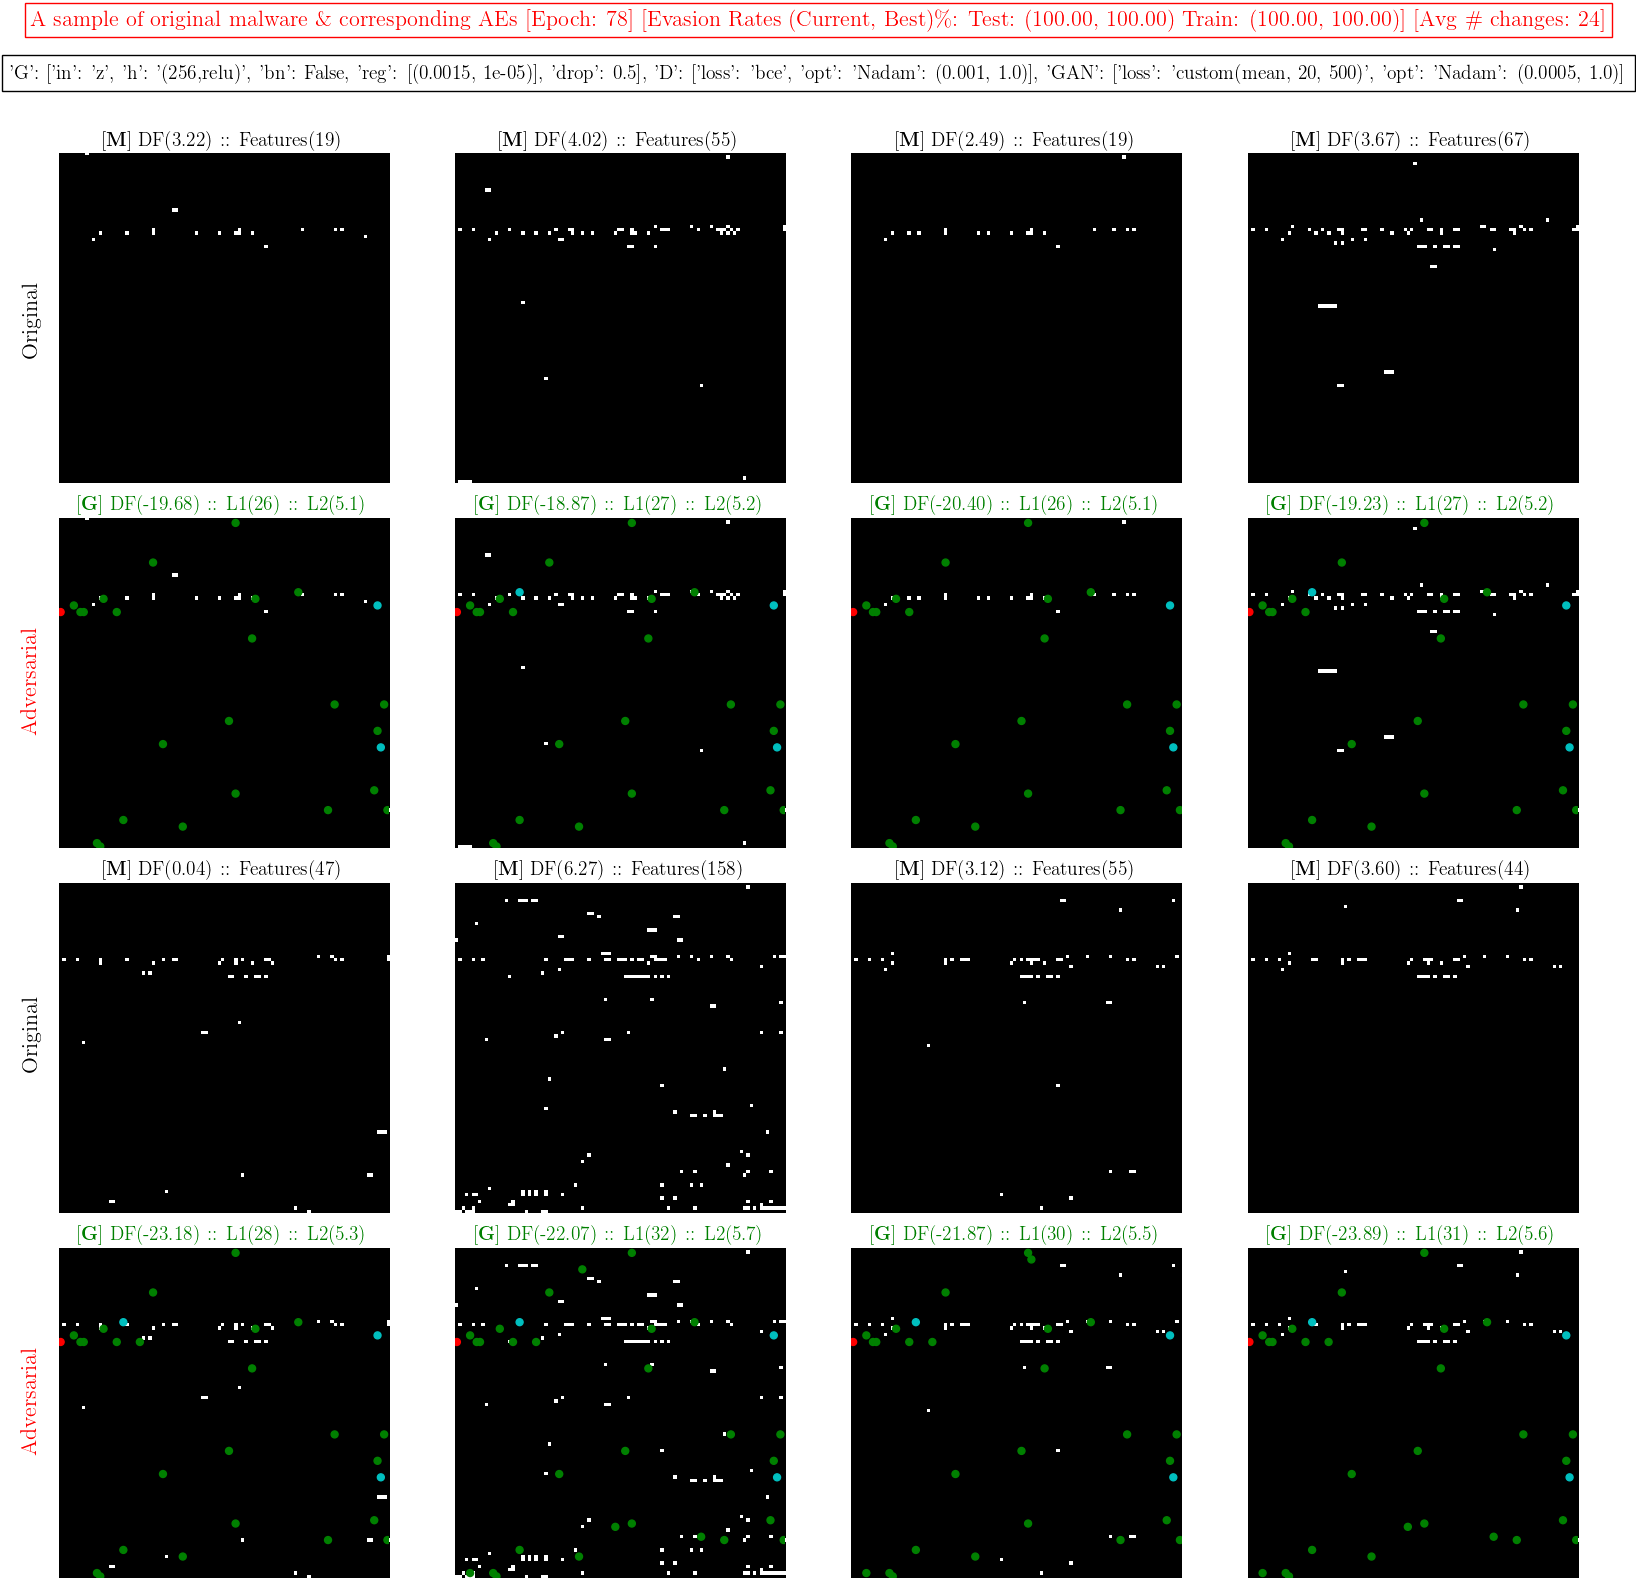


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [78] epochs, with avg 37.5 and max 42.0 changes per sample (on the test set) ... GAN Loss: [0.17455574]
######################################################################################################################################################



######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [79] epochs, with avg 21.5 and max 27.0 changes per sample (on the test set) ... GAN Loss: [0.11503802]
######################################################################################################################################################



#####################################################################################

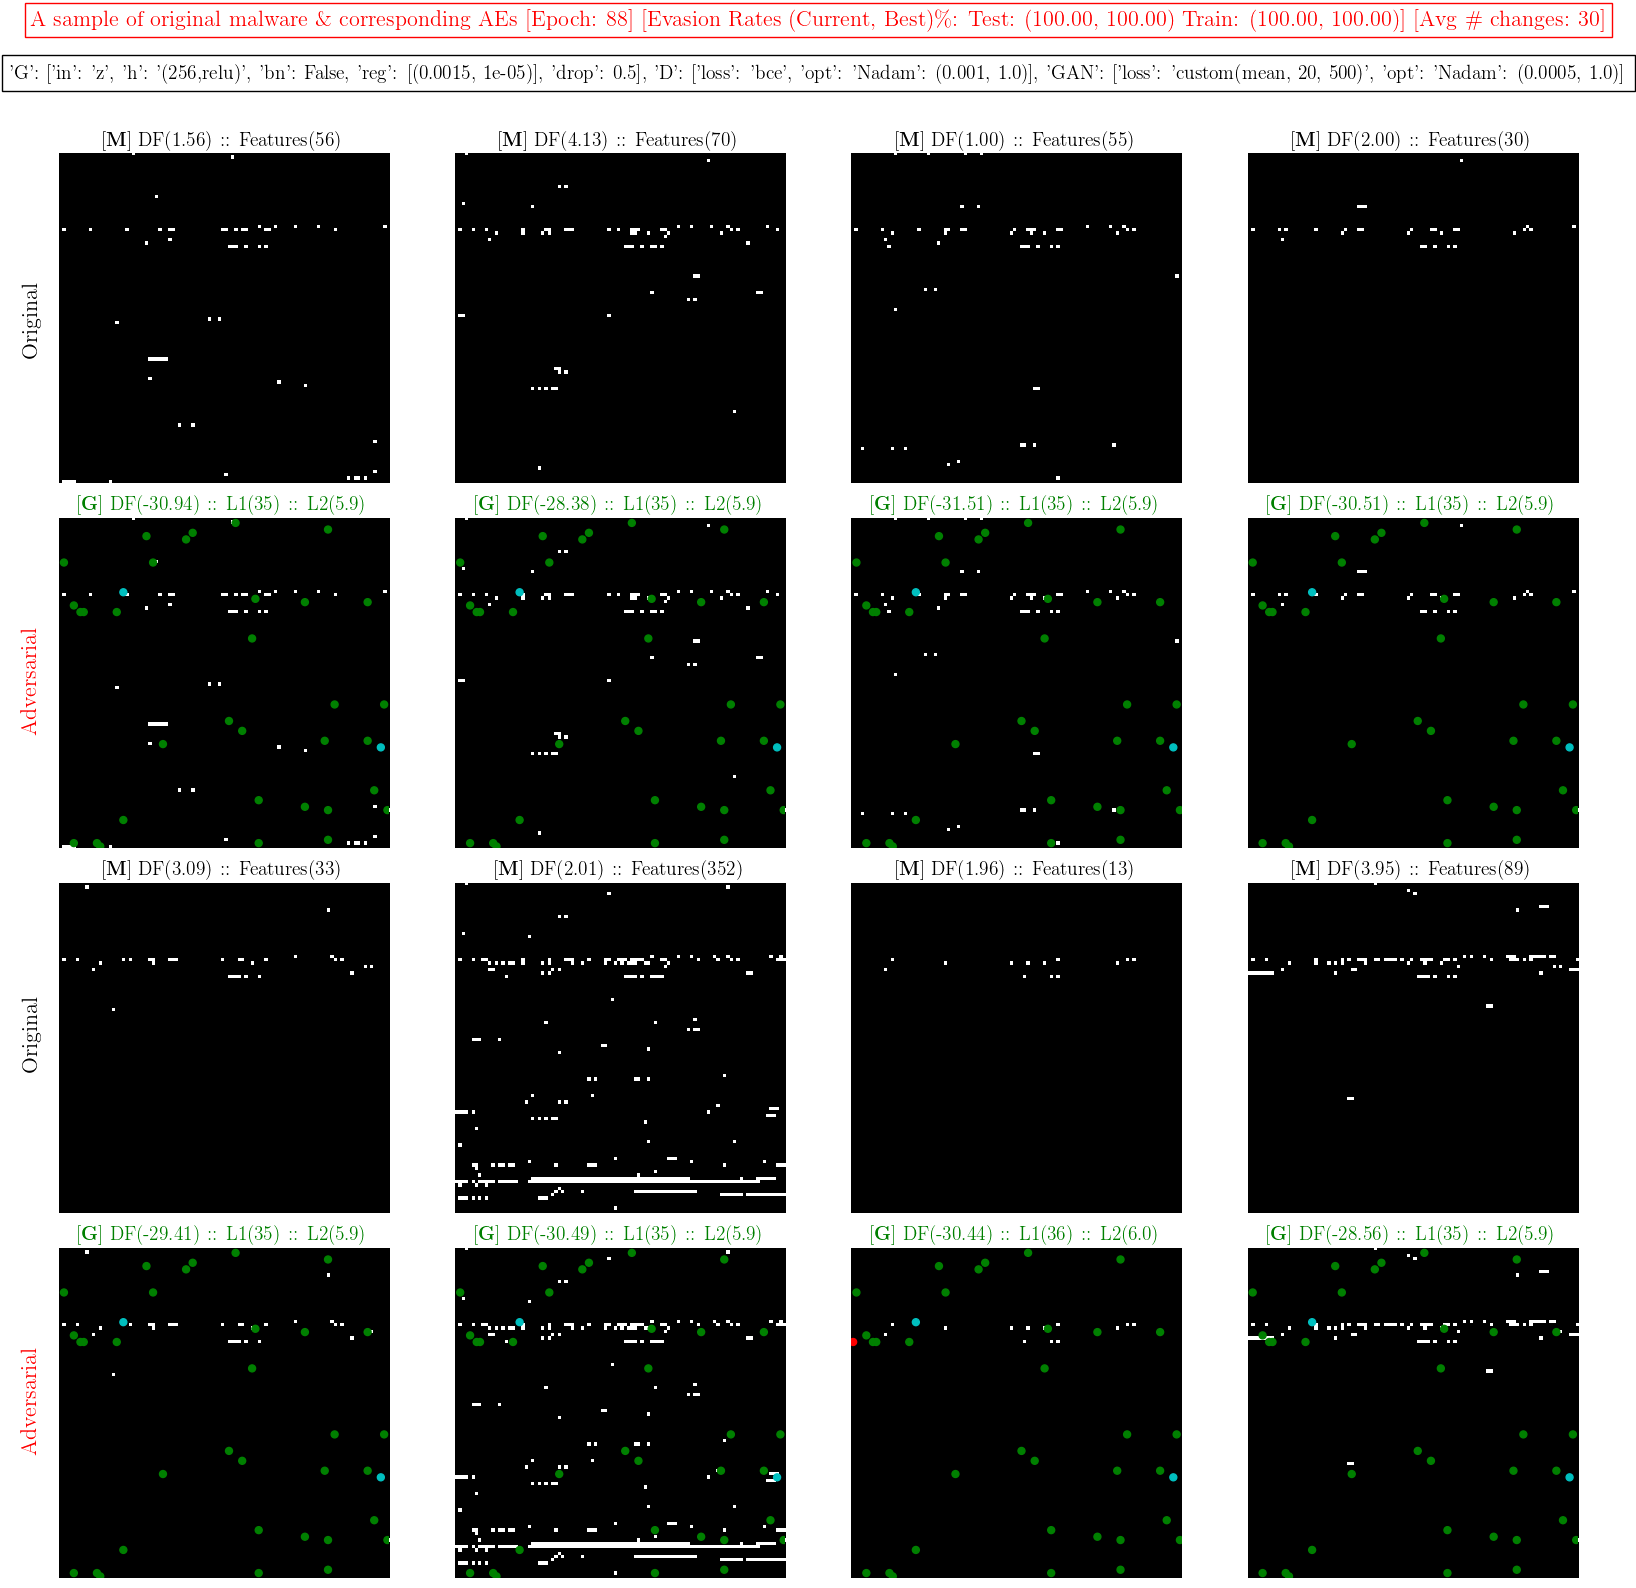


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [88] epochs, with avg 30.8 and max 31.0 changes per sample (on the test set) ... GAN Loss: [0.13310403]
######################################################################################################################################################



######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [89] epochs, with avg 29.6 and max 31.0 changes per sample (on the test set) ... GAN Loss: [0.10074046]
######################################################################################################################################################



#####################################################################################

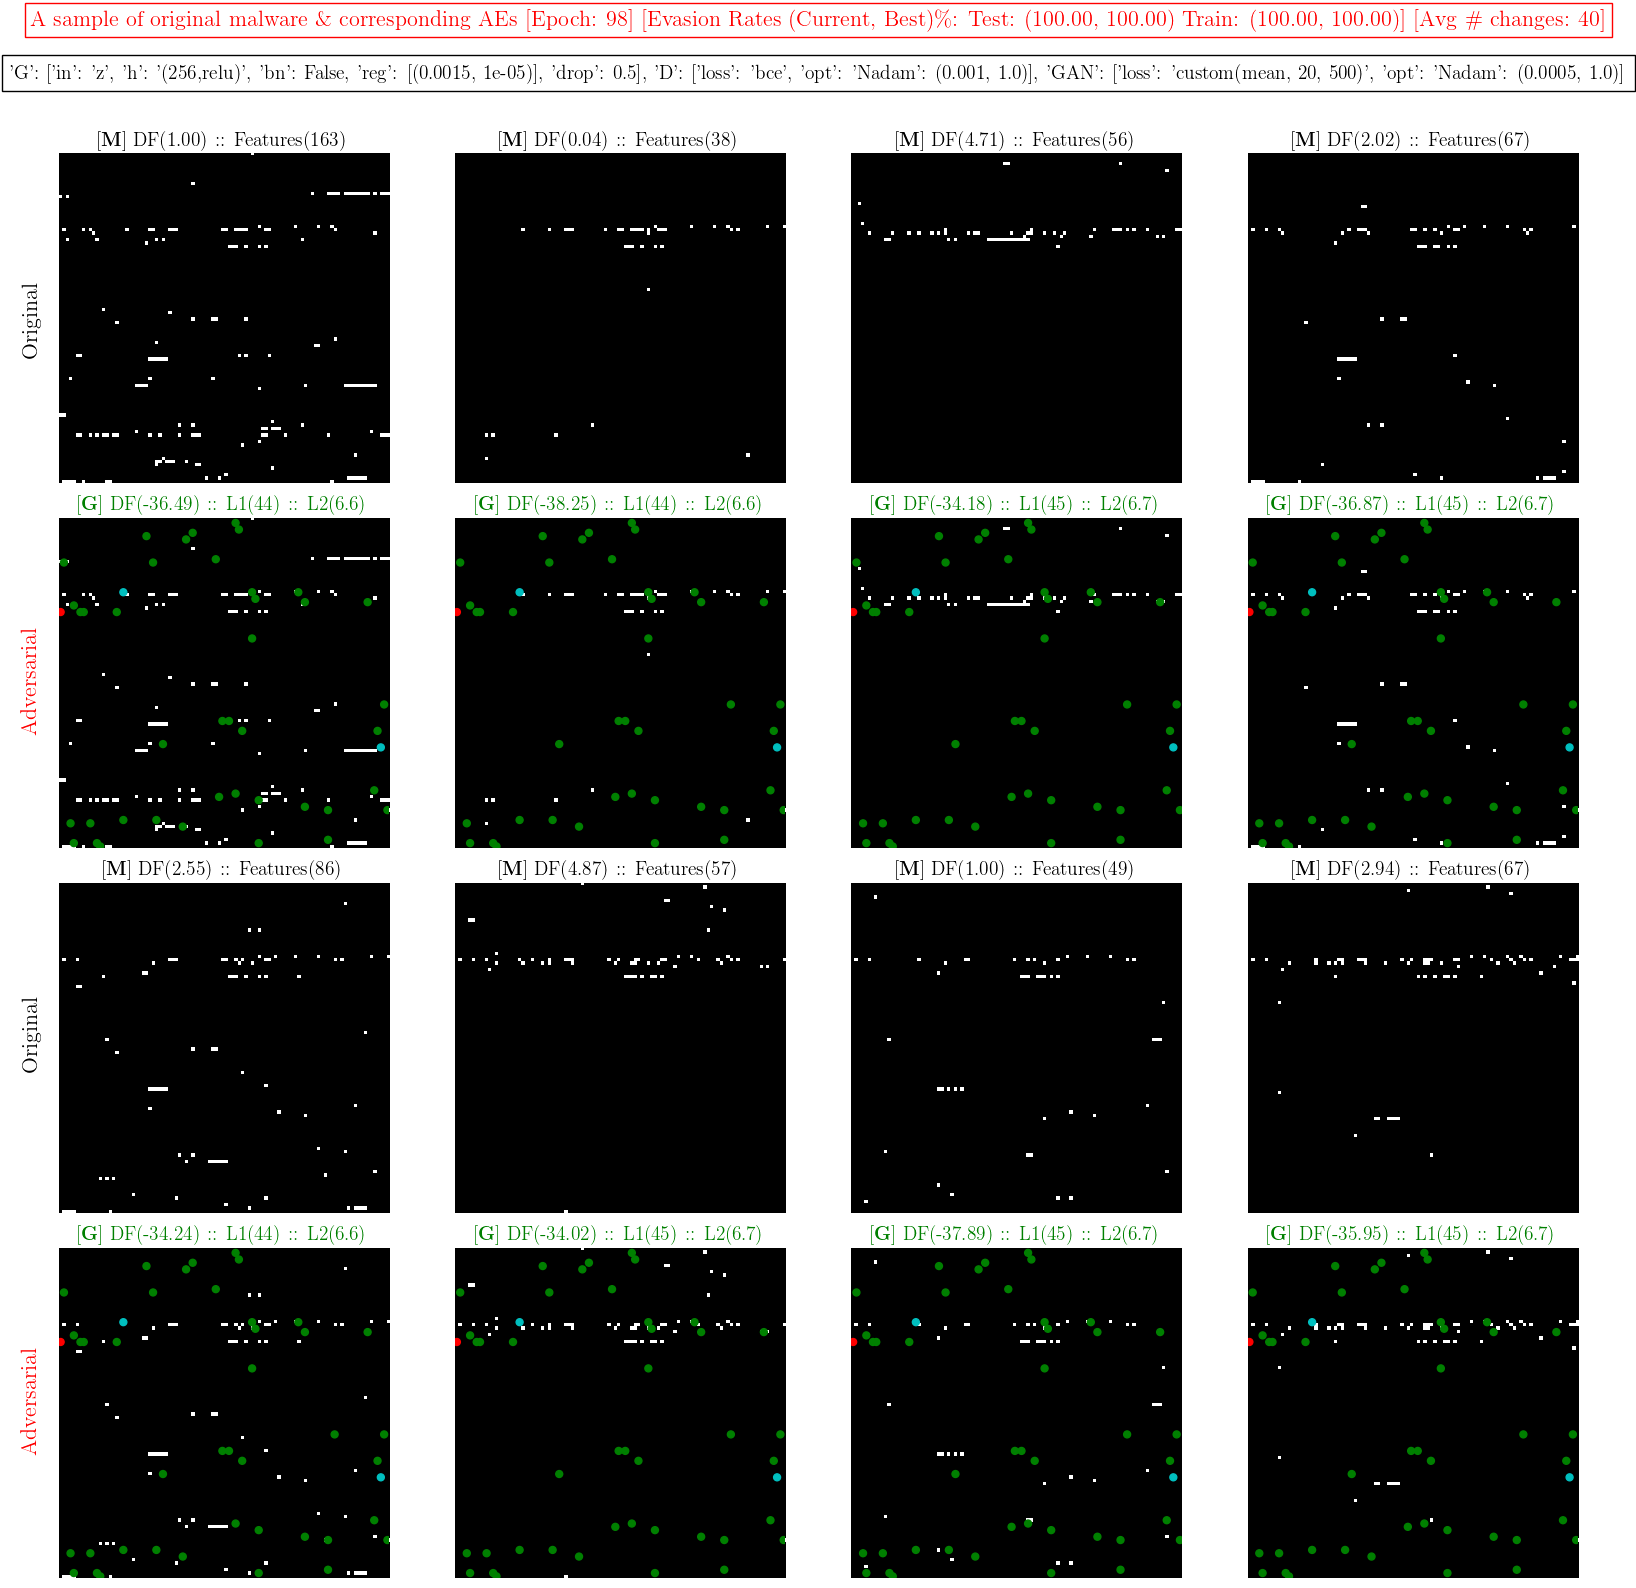


######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [98] epochs, with avg 26.3 and max 28.0 changes per sample (on the test set) ... GAN Loss: [0.15105705]
######################################################################################################################################################



######################################################################################################################################################
# Target Evasion Rate 100.00% achieved at epoch [99] epochs, with avg 43.6 and max 45.0 changes per sample (on the test set) ... GAN Loss: [0.17377593]
######################################################################################################################################################




####################################################################################

In [ ]:
%autoreload

epochs=100
batch_size = 32
# batch_size = TP_train.shape[0]        # whole dataset

TPR_train, TPR_test, avg_diff_train, avg_diff_test, d_metrics, gan_metrics, best_G_path = \
    evadeGAN.train(target_model=model, epochs=epochs, batch_size=batch_size, 
                   n_progress=10, d_times=1, d_train_mal=True, d_train_adv=True,
                   gan_times=1, good_label=GOOD_LABEL, mal_label=MAL_LABEL,
                   X_mal_train=X_mal_train, X_mal_test=X_mal_test, 
                   good_batch_factor=1, X_good_train=X_good_train, 
                   X_good_test=X_good_test, max_changes=max_changes,
                   minTPR_threshold=1-targetEvasionRate, 
                   gan_dir=GAN_DIR, smooth_alpha=1.0)

In [ ]:
%autoreload

### **Plot the TPR and training metrics**

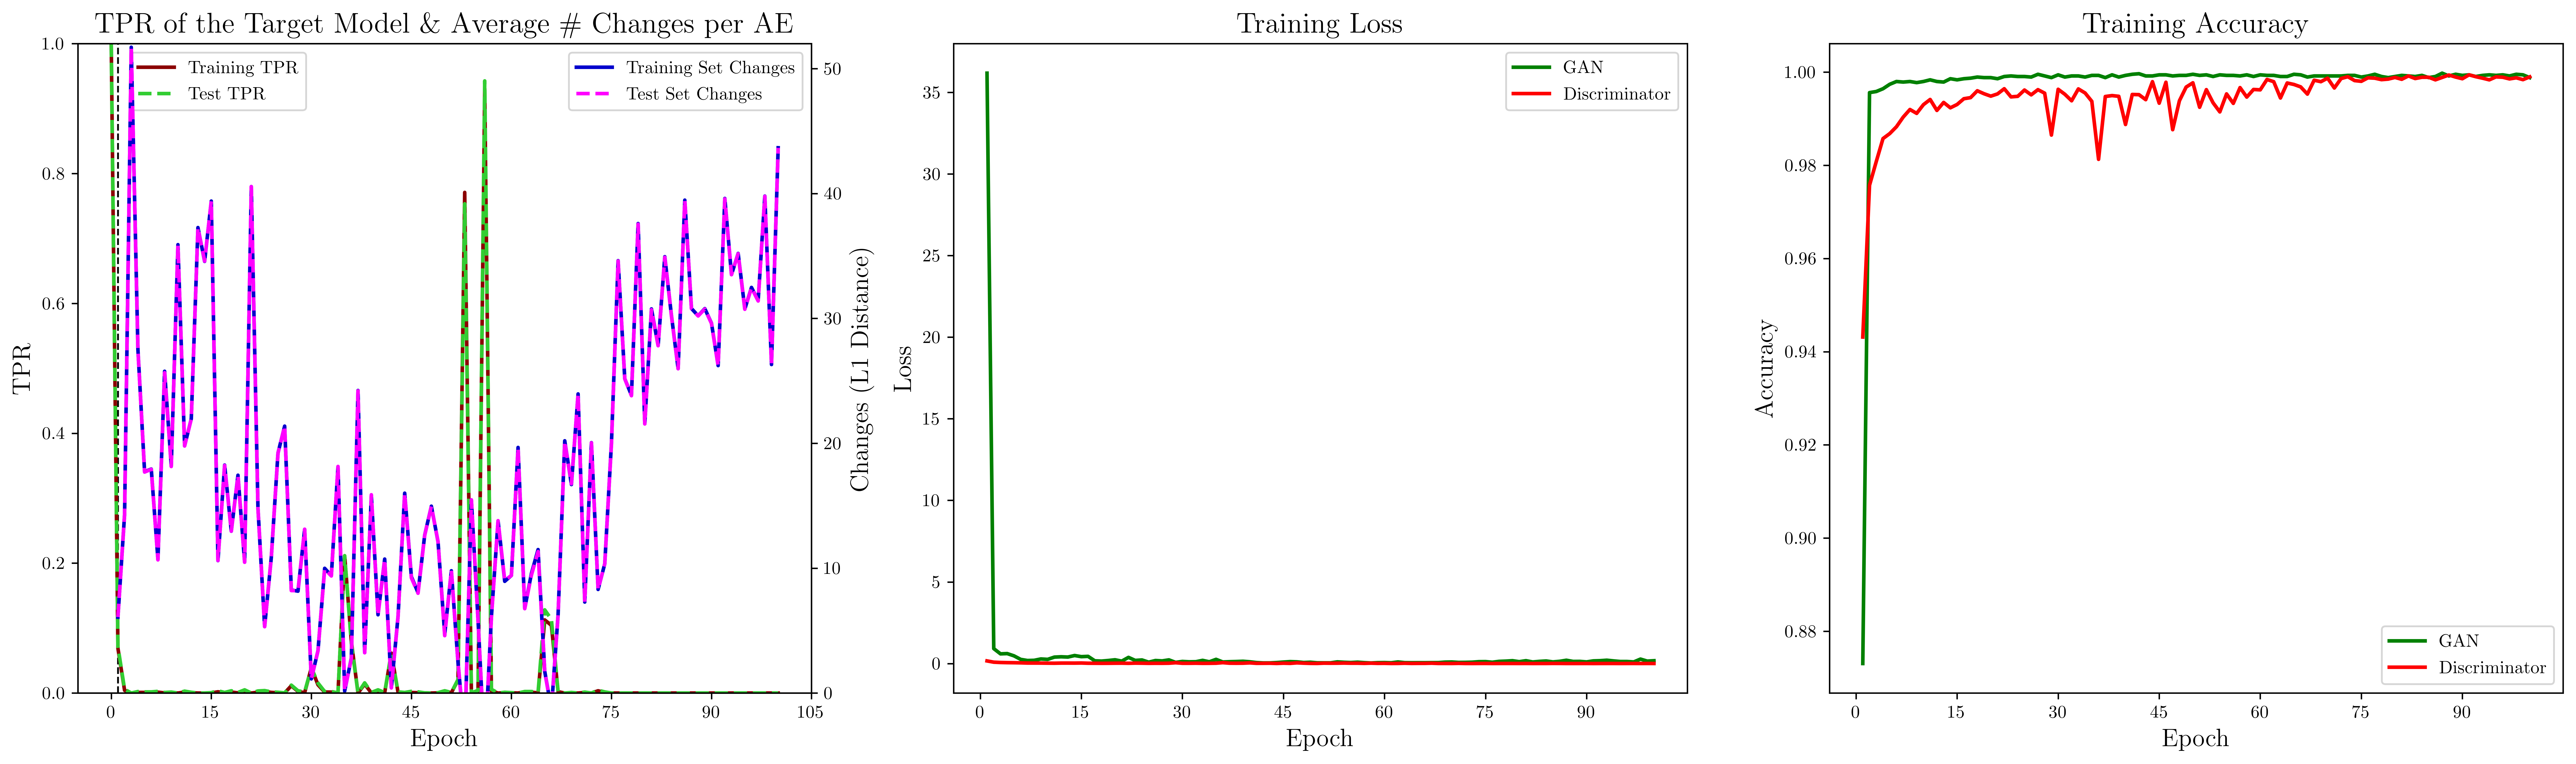

In [ ]:
%autoreload
plot_TPR_metrics(TPR_train, TPR_test, avg_diff_train, avg_diff_test, 
                 d_metrics, gan_metrics)

### **How well does the discriminator approximate the target model?**

The discriminator is evaluated on all the samples that are **correctly classified** by the **target model (True Positives & True Negatives)**.

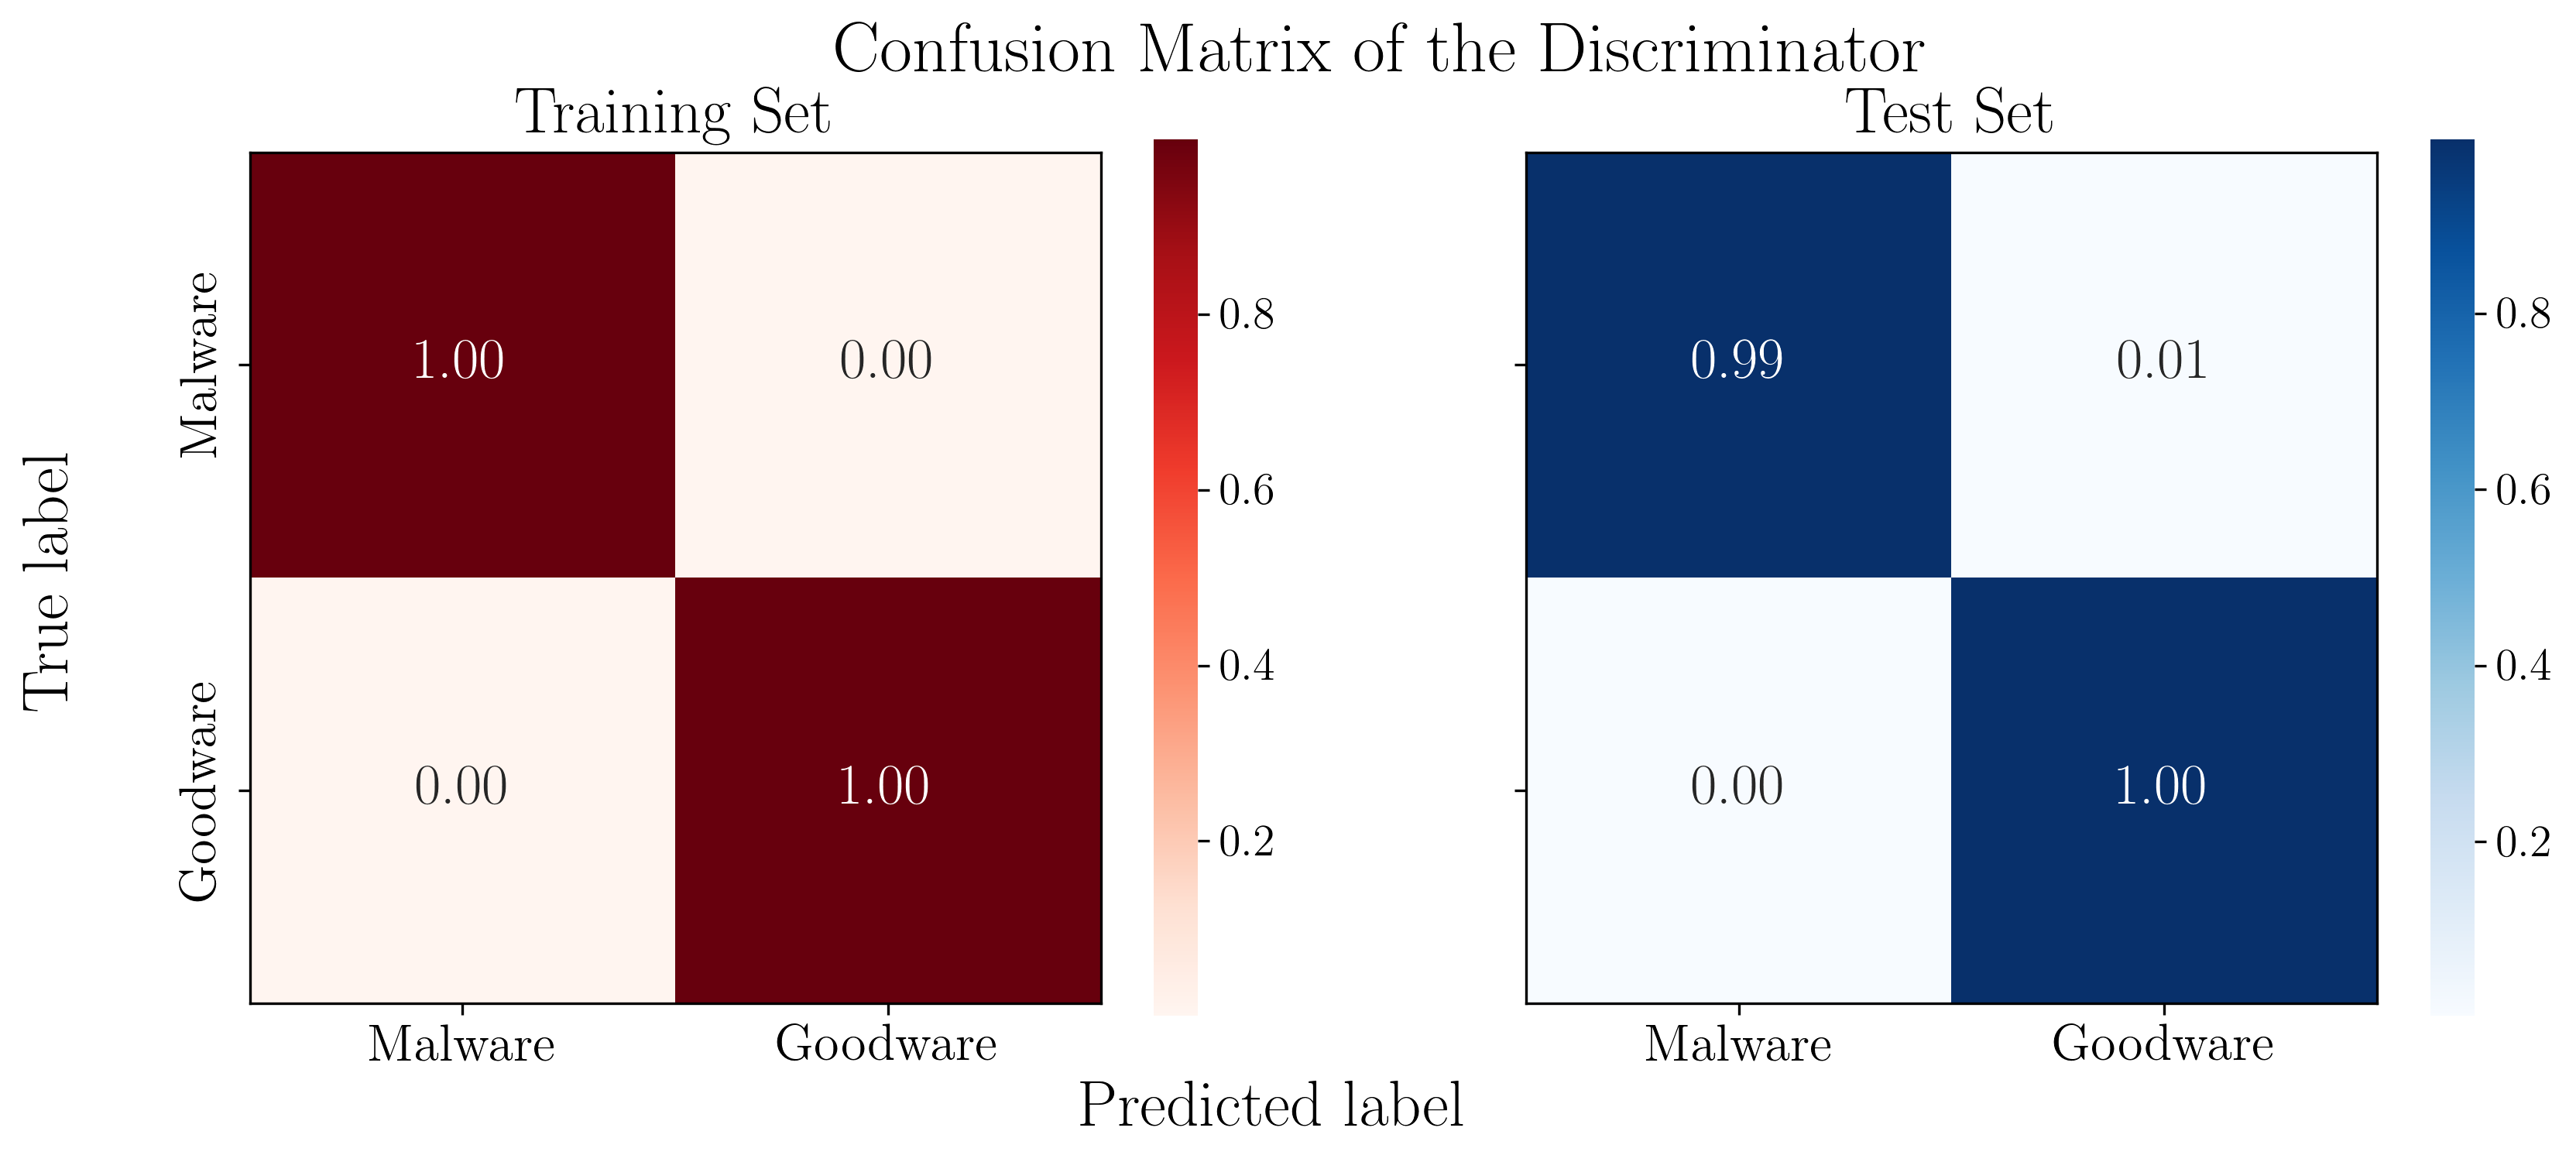

In [ ]:
%autoreload
# Evaluate discriminatior (how well does it approximate the target model)

Y_true_train = np.concatenate((MAL_LABEL * ones(X_mal_train.shape[0]),
                              GOOD_LABEL * ones(X_good_train.shape[0]))) 
Y_pred_train = \
    np.concatenate(
        (binarise(evadeGAN.discriminator.predict(X_mal_train), bin_threshold), 
        binarise(evadeGAN.discriminator.predict(X_good_train), bin_threshold))
    )

Y_true_test = np.concatenate((MAL_LABEL * ones(X_mal_test.shape[0]),
                              GOOD_LABEL * ones(X_good_test.shape[0]))) 
Y_pred_test = \
    np.concatenate(
        (binarise(evadeGAN.discriminator.predict(X_mal_test), bin_threshold),
         binarise(evadeGAN.discriminator.predict(X_good_test), bin_threshold))
    )

plot_confusion_matrix(Y_true_train, Y_pred_train, Y_true_test, Y_pred_test,
                      title="Confusion Matrix of the Discriminator")

## **Best Generator** ##



In [ ]:
generator = load_model(best_G_path)

In [ ]:
%autoreload
pd.options.display.max_rows = 1000

### **Generate AEs** ###

**A. Many X's and many Z's**

In [ ]:
# Matrix to array
x_good_train = np.asarray(X_good_train)   # To analyse perturbations
x_mal_train = np.asarray(X_mal_train)     # To analyse perturbations
x_mal_test = np.asarray(X_mal_test)       # To generate AEs

z = np.random.uniform(0.0, 1.0, size=[X_mal_test.shape[0], z_dim])

x_adv = generator.predict([X_mal_test, z])
x_adv = binarise(x_adv).numpy()               # Binary AE
perturbs = x_adv - x_mal_test                 # Delta = x' - x

**B. One X and many Z's (does changing z produce diverse AEs?)**

In [ ]:
N = 100
x_one = np.repeat(X_mal_test[0], N, axis=0)

z_one = np.random.uniform(0.0, 1.0, size=[N, z_dim])

x_adv_one = generator.predict([x_one, z_one])
x_adv_one = binarise(x_adv_one).numpy()         # Binary AE
perturbs_one = x_adv_one - x_one                # Delta = x' - x

#### Double-Check Evasion (Misclassification) ####

**A. Many X's and many Z's**

In [ ]:
y_adv = model.predict(x_adv)
print(f'{np.count_nonzero(y_adv)} AEs classified as malware.') # Evasive AEs?

0 AEs classified as malware.


**B. One X and many Z's (does changing z produce diverse AEs?)**

In [ ]:
y_adv_one = model.predict(x_adv_one)
print(f'{np.count_nonzero(y_adv_one)} AEs classified as malware.') # Evasive AEs?

0 AEs classified as malware.


## **Analyse Pertubations** ##

### **1. Unique pertubations** ###

**A. Many X's and many Z's**

In [ ]:
df_perturbs = pd.DataFrame(perturbs)
unique_perturbs = df_perturbs.drop_duplicates()
print(f"{'Numer of AEs:':<20} {X_mal_test.shape[0]}")
print(f"{'Unique Pertubations:':<20} {unique_perturbs.shape[0]}  "
      f"({100*unique_perturbs.shape[0]/X_mal_test.shape[0]:.2f}%)")

Numer of AEs:        3451
Unique Pertubations: 150  (4.35%)


In [ ]:
df_perturbs.astype(bool).sum(axis=1).describe()

count    3451.000000
mean       18.801217
std         1.339006
min        12.000000
25%        18.000000
50%        19.000000
75%        20.000000
max        21.000000
dtype: float64

**B. One X and many Z's (does changing z produce diverse AEs?)**

In [ ]:
df_perturbs_one = pd.DataFrame(perturbs_one)
unique_perturbs_one = df_perturbs_one.drop_duplicates()
print(f"{'Numer of AEs:':<20} {x_one.shape[0]}")
print(f"{'Unique Pertubations:':<20} {unique_perturbs_one.shape[0]}  "
      f"({100*unique_perturbs_one.shape[0]/x_one.shape[0]:.2f}%)")

Numer of AEs:        100
Unique Pertubations: 14  (14.00%)


In [ ]:
df_perturbs_one.astype(bool).sum(axis=1).describe()

count    100.00000
mean      19.23000
std        1.10878
min       14.00000
25%       19.00000
50%       20.00000
75%       20.00000
max       21.00000
dtype: float64

### **2. What Features were added in perturbations?** ###

In [ ]:
feature_names = data.get_feature_names()             
feature_weights = weights
perturb_count = pd.DataFrame(perturbs).astype(bool).sum(axis=0)         # Feature count in perturbations
mal_test_count = pd.DataFrame(X_mal_test).astype(bool).sum(axis=0)      # Feature count in testing malware
mal_train_count = pd.DataFrame(X_mal_train).astype(bool).sum(axis=0)    # Feature count in training malware
good_train_count = pd.DataFrame(X_good_train).astype(bool).sum(axis=0)  # Feature count in training goodware

df = pd.DataFrame({'FeatureName': feature_names,
                   'FeatureWeight': feature_weights,
                   'malTestCount': mal_test_count,
                   'malTrainCount': mal_train_count,
                   'malTrainFreq': mal_train_count / X_mal_train.shape[0],
                   'goodTrainCount': good_train_count,
                   'goodTrainFreq': good_train_count / X_good_train.shape[0],
                   'PerturbCount': perturb_count})

### **2.1. Features sorted by perturbation count (Descending)** ###

Check their **weights** and **frequencies** in *malware* (**training** and **test** sets) and *goodware*.

In [ ]:
df.sort_values(['PerturbCount'], ascending=False).round(5).head(100)   # Top 100

FeatureName  FeatureWeight  \
2459  app_permissions::name='android_permission_WRIT...       -1.00000   
8353    urls::http://www_ngs_ac_uk/tools/jcepolicyfiles       -0.50061   
9804             urls::https://twitter_com/%s/status/%d       -1.04500   
1301  activities::com_qbiki_seattleclouds_SettingsAc...       -0.87384   
6831            urls::http://portre_yemonisoni_com/mcla       -2.47986   
1328          activities::com_revmob_FullscreenActivity       -1.77385   
8881                     urls::https://api_parse_com/1/       -1.00823   
2817   interesting_calls::Cipher(RSA/None/PKCS1Padding)       -1.09402   
2593     intents::android_intent_action_PACKAGE_CHANGED       -0.77441   
5698               urls::http://iframe_ip138_com/ic_asp       -1.15134   
440   activities::com_amazon_ags_html5_overlay_GameC...       -0.71221   
6455             urls::http://my_mobfox_com/request_php       -1.00868   
8774                   urls::https://ad_mail_ru/mobile/       -1.11570   
9337  urls::https://graph_facebook_com/%1$s?fields=n...       -1.00000   
153                          activities::_IntroActivity       -0.86461   
8295  urls::http://www_jivesoftware_com/xmlns/xmpp/p...       -0.84291   
5683                       urls::http://i_ytimg_com/vi/       -1.40111   
8448  urls::http://www_startappexchange_com/1_3/trac...       -2.10412   
9119                       urls::https://app_adjust_com       -0.77310   
2604       intents::android_intent_action_SEND_MULTIPLE       -0.90028   
381        activities::cn_jpush_android_ui_PushActivity       -0.52976   
6670  urls::http://p_apkw_cn:6969/adv_platform/servi...       -0.00000   
6669  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6668  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6672  urls::http://p_apkw_cn:6969/adv_platform/servi...       -0.00000   
6671  urls::http://p_apkw_cn:6969/adv_platform/servi...       -0.00000   
6673  urls::http://p_apkw_cn:6969/adv_platform/servi...       -0.00000   
6666  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6665  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6674  urls::http://p_apkw_cn:6969/adv_platform/servi...       -0.00000   
6675  urls::http://p_apkw_cn:6969/adv_platform/servi...       -0.00000   
6667  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
0                                   activities::5+Debug       -0.00000   
6664  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6654     urls::http://otile3_mqcdn_com/tiles/1_0_0/map/       -0.13943   
6647  urls::http://ota_iqiyi_com/adf/6ca2567badad4aa...       -0.00000   
6648  urls::http://oth_eve_mdt_qq_com:8080/analytics...       -0.12313   
6649  urls::http://oth_str_mdt_qq_com:8080/analytics...       -0.12313   
6650     urls::http://otile1_mqcdn_com/tiles/1_0_0/map/       -0.13943   
6651     urls::http://otile1_mqcdn_com/tiles/1_0_0/sat/       -0.13943   
6652     urls::http://otile2_mqcdn_com/tiles/1_0_0/map/       -0.13943   
6653     urls::http://otile2_mqcdn_com/tiles/1_0_0/sat/       -0.13943   
6655     urls::http://otile3_mqcdn_com/tiles/1_0_0/sat/       -0.13943   
6663  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6656     urls::http://otile4_mqcdn_com/tiles/1_0_0/map/       -0.13943   
6657     urls::http://otile4_mqcdn_com/tiles/1_0_0/sat/       -0.13943   
6658          urls::http://ox_appnext_com/www/delivery/       -0.56185   
6659              urls::http://p_amail_com_cn/portrait/        0.27981   
6660  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6661  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6662  urls::http://p_amail_com_cn/pushmessage/cloudm...        0.27981   
6676                       urls::http://p_scoreloop_com       -0.17861   
6681  urls::http://partner_vip_qiyi_com/mobact/feedb...        0.09583   
6677            urls::http://p_scoreloop_com/use

In [ ]:
df.sort_values(['FeatureWeight'], ascending=False).round(5).head(100).to_csv('features_top_pos.csv', sep='\t')

### **2.2. Features sorted by weights (Ascending)** ###

In [ ]:
df.sort_values(['FeatureWeight'], ascending=True).round(5).head(100)

FeatureName  FeatureWeight  \
6831            urls::http://portre_yemonisoni_com/mcla       -2.47986   
8448  urls::http://www_startappexchange_com/1_3/trac...       -2.10412   
1328          activities::com_revmob_FullscreenActivity       -1.77385   
6828                  urls::http://pms_mb_qq_com/rsp204       -1.66521   
3658                    urls::http://admin_appnext_com/       -1.61378   
8236      urls::http://www_google-analytics_com/collect       -1.57233   
3694          urls::http://ads_mobilecore_com/?package=       -1.44954   
2806  interesting_calls::Cipher(Lorg/chromium/base/O...       -1.41060   
5683                       urls::http://i_ytimg_com/vi/       -1.40111   
9744    urls::https://sites_google_com/site/gamegripper       -1.32769   
307        activities::_ads_vast_VideoAdsLoaderActivity       -1.29557   
6546            urls::http://opds-spec_org/2010/catalog       -1.28479   
8562                urls::http://www_youtube_com/embed/       -1.25572   
6314  urls::http://mobads_baidu_com/cpro/ui/mads_php...       -1.22401   
5924             urls::http://loc_map_baidu_com/tcu_php       -1.21986   
8450  urls::http://www_startappexchange_com/tracking...       -1.21676   
2354      api_permissions::android_permission_READ_LOGS       -1.19574   
5698               urls::http://iframe_ip138_com/ic_asp       -1.15134   
175                               activities::_MAME4all       -1.13175   
8774                   urls::https://ad_mail_ru/mobile/       -1.11570   
197                  activities::_MonacaSScreenActivity       -1.10277   
4637  urls::http://data_altbeacon_org/android-distan...       -1.09506   
2817   interesting_calls::Cipher(RSA/None/PKCS1Padding)       -1.09402   
7363  urls::http://strategy_beacon_qq_com/analytics/...       -1.09165   
2141             activities::org_jufh_xmvo_woeiwej_Suzi       -1.09027   
8560                       urls::http://www_youtube_com       -1.08235   
9912   urls::https://www_googleapis_com/oauth2/v1/certs       -1.07974   
6793    urls::http://play_google_com/store/apps/details       -1.07395   
4148            urls::http://api_w_inmobi_com/showad/v2       -1.04519   
9804             urls::https://twitter_com/%s/status/%d       -1.04500   
2539  app_permissions::name='getui_permission_GetuiS...       -1.03644   
6638  urls::http://openmobile_qq_com/oauth2_0/m_jump...       -1.03137   
4669                      urls::http://debugtbs_qq_com/       -1.02463   
9053  urls::https://api_weibo_com/2/statuses/mention...       -1.02410   
9046  urls::https://api_weibo_com/2/statuses/friends...       -1.02410   
9041             urls::https://api_weibo_com/2/statuses       -1.01492   
6455             urls::http://my_mobfox_com/request_php       -1.00868   
8881                     urls::https://api_parse_com/1/       -1.00823   
146                        activities::_ISniperActivity       -1.00000   
5839  urls::http://kairopark_jp/j7hjT4ua/gm30/depart...       -1.00000   
9337  urls::https://graph_facebook_com/%1$s?fields=n...       -1.00000   
327                            activities::_krazyracers       -1.00000   
8567                 urls::http://www_youtube_com/watch       -1.00000   
9112  urls::https://apigee_com/oauth_callback/instag...       -1.00000   
9919       urls::https://www_growingio_com/oauth2/token       -1.00000   
886                   activities::com_forthblue_aq_Main       -1.00000   
6011                           urls::http://m_iqiyi_com       -1.00000   
304                   activities::_activity_WelActivity       -1.00000   
900               activities::com_fw_toth_activity_FwMA       -1.00000   
2459  app_permissions::name='android_permission_WRIT...       -1.00000   
4570  urls::http://cq01-cm-et01_cq01_baidu_com:8192/...       -0.99531   
2811  interesting_calls::Cipher(PBEWithSHA256And256B...       -0.99153   
9902  urls::https://www_googleapis_com/auth/games_fi...       -0.99016   
9525                   urls::https://openmobile_

# **End** ⏹